In [2]:
from qutip import *
from matplotlib import cm
from matplotlib.gridspec import GridSpec as GS
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import qutip.qip
from scipy.optimize import curve_fit
from copy import copy,deepcopy
import qutip.qip.circuit_latex


c:\Users\1163080609\anaconda3\Lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [3]:
def g():
    fig = plt.figure()
    spec = GS(ncols=2, nrows=1, 
            left=0.1, right=0.9, 
            bottom=0.1, top=0.9, 
            width_ratios=[2, 1],
            wspace=0)

    # 4. 建立对应坐标系
    ax1 = fig.add_subplot(spec[0])  # 第一行第一列
    ax2 = fig.add_subplot(spec[1])  # 第一行第二列


    # 5. 为每个子图生成一些示例数据并绘制
    for ax in [ax1, ax2,]:
        ax.plot(np.random.rand(5), np.random.rand(5), 'o-')

    # 6. 调整子图之间的间距（如果需要）
    # 在GridSpec创建时，我们已经通过wspace和hspace参数设置了间距
    # 但如果需要进一步调整，可以在这里使用plt.subplots_adjust()方法

    # 7. 展示图形
    plt.show()


<>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
C:\Users\1163080609\AppData\Local\Temp\ipykernel_14024\870034709.py:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  r'g'()


TypeError: 'str' object is not callable

In [4]:
class sideband:
    def __init__(self,**params) -> None:
        '''
        level,t_edge,|||
        w,yita,g,|||
        L,wd,phid,amp,sp,|||
        rho0,rho_tar|||

        (w+k)n-k/12(x**4)=wn-k/2*ad*ad*a*a
        '''

        self.params={
        # qcircuit
        'level':3,          'hascoupler':False,
        # qubtrit params,   GHz/2pi
        'w':[7,5,0],        'yita':[100,300,0],         'g':[100,0,0],
        # drive params,      GHz/2pi,rad,1
        # tp is time_pointer
        'wd':[5.15,6],      'phid':[0,0],               'sp_eff':[1,0],
        'sp_direct':None,   'arrow_ideal':[1,1,1],      'tp':0,

        # envelope,         ns,ns,GHz/2pi
        'L':100,            't_edge':10,               'amp':0.1,
        # simulate
        'Tstep':None,       'rho0':0,                  'rho_tar':None,
        'ksp':None,         'pre_scan':False,          'mix':False 
        }

        self.params.update(params)
        self.params0=copy(self.params)
        self.__setparams(self.params)
   
    def __setparams(self,dic):
        for p in dic:
            setattr(self,p,dic[p])
        
        # qcircuit
        global n
        n=self.level

        # ideal arrow/target state
        self.arrow_squ,self.arrow_norm,\
        self.p_ideal,self.t_coeff=self.ideal


        # qubtrit params,   GHz,MHz,MHz
        self.H0=self.__H0
        self.ee,self.es,self.proj=self.__eigen
        self.e1,self.e2=self.ee[2],self.ee[1]
        self.e11,self.e22=self.ee[self.to(1)],self.ee[self.to(2)]
        
        # params pre_guess
        if  self.pre_scan:
            self.ws_g,self.wp_g=self.wd[0],self.wd[1]
        else:
            self.ws_g=self.e11/2
            self.wp_g=(self.e22-self.e11)/2
        self.wd_g=[self.ws_g,self.wp_g]
        self.ks_g=1/(self.e1-self.ws_g)+1/(self.e1+self.ws_g)
        self.kp_g=1/(self.e1-self.wp_g)+1/(self.e1+self.wp_g)

        # drive
        self.ws,self.wp=self.wd[0],self.wd[1]
        self.envelope=self.__envelope
        self.up_edge,self.down_edge,self.plant=self.__envelope_slice
        self.ks,self.kp,self.sp=self.__sp
        self.DS,self.UDS,self.DDS,self.PDS=self.__DS
        self.HD=self.__HD

        # d
        self.ds_g=2*(self.sp[0]*self.amp*self.ks_g)**2*\
            self.yita[0]*self.g[0]/(self.e1-self.e2)
        # 差了4倍
        self.ds_g=self.ds_g/4

        self.dp_g=4*(self.sp[1]*self.amp*self.kp_g)**2*\
            self.yita[0]*self.g[0]/(self.e1-self.e2)
        # 差了2倍
        self.dp_g=self.dp_g/2
        self.d_eff_g=[self.ds_g,self.dp_g]
        
        self.T_g=8/(2*(self.amp*self.ks_g)**2*\
            self.yita[0]*self.g[0]/(self.e1-self.e2))
 

        # simulate
        if self.Tstep==None:    
            self.Tstep=int(self.L*10*5+1)
        self.H=[2*np.pi*self.H0,[2*np.pi*self.HD,self.DS]]
        self.H_up       =[2*np.pi*self.H0,[2*np.pi*self.HD,self.UDS]]
        self.H_down     =[2*np.pi*self.H0,[2*np.pi*self.HD,self.DDS]]
        self.H_plant    =[2*np.pi*self.H0,[2*np.pi*self.HD,self.PDS]]
        self.tlist=np.linspace(0,self.L,self.Tstep)
        if self.rho_tar==None:
            self.rho_tar=self.rho0+1
    
    def update(self,dic=(),**params):
        self.params.update(dic)
        self.params.update(params)
        self.__setparams(self.params)

    @property
    def ideal(self):
                # ideal arrow/target state
        am=np.linalg.norm(self.arrow_ideal)
        a_squ=[(i/am)**2 for i in self.arrow_ideal]
        a_nor=[i/am for i in self.arrow_ideal]
        x,y=a_nor[0],a_nor[1]
        fp=-(y**2+2*x-2)/(x**2-2*x+1)
        p_ide=np.sqrt(fp-1)
        t_coeff=np.arccos(1+x*fp-fp)/2/np.pi
        return a_squ,a_nor,p_ide,t_coeff


    @property
    def __envelope(self):
        return lambda t,args:\
            self.amp*(0.5*np.cos(np.pi*t/self.t_edge-np.pi)+0.5)\
        if 0<=t<=self.t_edge else\
            self.amp*(0.5*np.cos(np.pi*(t-self.L)/self.t_edge-np.pi)+0.5)\
        if (self.L-self.t_edge)<=t<=self.L else\
            self.amp\
        if self.t_edge<t<(self.L-self.t_edge) else 0
    @property
    def __envelope_slice(self):
        return lambda t,args:\
            self.amp*(0.5*np.cos(np.pi*(t-self.tp)/self.t_edge-np.pi  )+0.5),\
            lambda t,args:\
            self.amp*(0.5*np.cos(np.pi*(t-self.tp)/self.t_edge        )+0.5),\
            lambda t,args: self.amp

    
    @property 
    def __sp(self):
        sp_eff,         ks_g,       kp_g,       ws,         wp=\
        self.sp_eff,    self.ks_g,  self.kp_g,  self.ws,    self.wp
        ks,kp,sp=0,0,0
        sp=[0,0]
        # theoral:sp=[sp_eff[0],np.sqrt(sp_eff[1]*0.5)*(ks_g/kp_g)]

        ks=1/(self.e1-ws)+1/(self.e1+ws)
        kp=1/(self.e1-wp)+1/(self.e1+wp)
        if self.ksp==None:    
            ksp=0.5*(ks_g/kp_g)
        else:
            ksp=self.ksp
        self.ksp_g=ksp
        if self.sp_direct==None:
            sp[0]=sp_eff[0]
            sp[1]=np.sqrt(sp_eff[1])*ksp
        else:
            sp=self.sp_direct
        return ks,kp,sp
    @property
    def __DS(self):
        DS=lambda t,args:0
        UDS,DDS,PDS=lambda t,args:0,lambda t,args:0,lambda t,args:0
        def cos(sp,a,w,phi): 
            return lambda t,args:sp*a(t,args)*np.cos(2*np.pi*w*t+phi)
        def add(f1,f2):
            return lambda t,args:f1(t,args)+f2(t,args)

        for i in range(len(self.wd)):
            DS =add(cos(self.sp[i],self.envelope,
                       self.wd[i],self.phid[i]),DS)
        for i in range(len(self.wd)):
            UDS=add(cos(self.sp[i],self.up_edge,
                       self.wd[i],self.phid[i]),UDS)
        for i in range(len(self.wd)):
            DDS=add(cos(self.sp[i],self.down_edge,
                       self.wd[i],self.phid[i]),DDS)
        for i in range(len(self.wd)):
            PDS=add(cos(self.sp[i],self.plant,
                       self.wd[i],self.phid[i]),PDS)
        
        return DS,UDS,DDS,PDS
    @property
    def __HD(self):
        a=destroy(n)
        ad=create(n)
        I=qeye(n)
        D=tensor(a+ad,I)
        return D       
    @property
    def __H0(self):
        w,g,yita=self.w,self.g,self.yita
        a,ad,I=destroy(15),create(15),qeye(n)
        x=a+ad
        def trunc(x):
            return Qobj(x[:n,:n])

        h0=(w[0]+yita[0])*ad*a-yita[0]/12*(x**4)
        h1=(w[1]+yita[1])*ad*a-yita[1]/12*(x**4)

        h0,h1=trunc(h0),trunc(h1)
        G01=g[0]*tensor(trunc(x),trunc(x))

        H0=tensor(h0,I)+tensor(I,h1)+G01
        return H0 
            # return trunc(h0)
    @property
    def __eigen(self):
        to,L=self.to,self.L
        eigen=self.H0.eigenstates()
        ee=[e-eigen[0][0] for e in eigen[0]]
        es=eigen[1]
        proj=[s*s.dag() for s in es]
        xita1=2*np.pi*ee[to(1)]*L
        xita2=2*np.pi*ee[to(2)]*L
        self.state_mix=(es[0]+
                        np.exp(-1j*xita1)*es[to(1)]+
                        np.exp(-1j*xita2)*es[to(2)]).unit()
        self.rho_mix=self.state_mix*self.state_mix.dag()
        # self.ground_state=es[0]
        # self.max_mixed_state
        return ee,es,proj  
    def drive_sign_plot(self,target='DS'):
        if target=='DS':
            func=self.DS
        elif target=='envelope':
            func=self.envelope
        fix,ax=plt.subplots()
        ax.plot(self.tlist,list(map(func,self.tlist,self.tlist)))
    def to(self,x):
        #n=3,4,5 p22=p[8,11,12] ,
        #assume 11,22 setten at middle of exciting number subspace
        #without consider 30 exceed 04
        #assume w2=2w-yita,w3=3w-2yita
        if x==0:
            return 0
        elif x==1:
            return 4
        elif x==2:
            if n==3:
                return 8
            elif n==4:
                return 11
            elif n==5:
                return 12
            elif n>=6:
                return 13
    def g_Level(self,target=None,gstop=None):
        if gstop==None:
            gstop=self.g[0]
        z=[]
        glist=np.linspace(0,gstop,100)
        for p in glist:
            self.update(g=[p])
            ee=self.ee
            z.append(ee)
        z=np.transpose(z)
        fix,ax=plt.subplots()
        if target==None:
            ax.plot(glist,np.transpose(z))
        else:
            ax.plot(glist,z[self.to(target)])
    

    def result_norm(self,result):
        res=result
        res.expect=[[i/j for i,j in zip(res.expect[k],res.expect[3])] 
                    for k in range(len(result.expect))]
        return res
    def scan_wd(self,wstart,wstop,wstep,sp=0,runplot=False,plot=True):
        '''
        sp=0,wd=[w_scan,wp]
        sp=1,wd=[ws,w_scan]
        '''
        rho0,rho_tar=self.rho0,self.rho_tar
        wdlist=np.linspace(wstart,wstop,wstep)
        wd=self.wd
        z=[]
        for w in wdlist:
            wd[sp]=w
            # wdt=[lambda t,args:wd]
            self.update(wd=wd)
            result=self.run(plot=runplot)
            z.append(np.transpose(result.expect))
        z=np.transpose(z)
        print(shape(z))

        if plot:
            self.imshow([z[rho_tar],wstart,wstop,wstep],rho_tar)

        return [z,wstart,wstop,wstep,wdlist]
    def find_w_mat(self,input,target=None,plot=False):
        z,          wstart,     wstop,      wstep,      wdlist=\
        input[0],   input[1],   input[2],   input[3],   input[4]
        dom=wstop-wstart
        dpi=(wstop-wstart)/wstep
        error=list(np.min(z[-1],axis=0))
        w_arg=np.argmin(error,axis=0)
        wm_guess=wdlist[w_arg]
        isside= w_arg==0 or w_arg==wstep-1
        return [wm_guess,dom,dpi,isside]
    
    def GateProcess(self,result,population=True,bloch=True,show_list=[0,1,2,3,-1]):
        if population:
            fig, ax = plt.subplots()
            ax.plot(result.times ,
            # np.transpose([result.expect[p]]))
            # np.transpose([expect for expect in result.expect]))
            np.transpose([result.expect[i] for i in show_list]))
            ax.set_xlabel('t/ns')
            ax.set_ylabel('Population')
            ax.legend(['P00','P11','P22','tot','error'])
            plt.show()
        if bloch:
            b=Bloch()
            b.add_points([result.expect[0],result.expect[1],
                          result.expect[2]],'l')
            b.show()


    def run_lego(self,  res_pre=None,   enve_type='p',      L=None,
                        plot=False,     population=True,    bloch=False,):
        '''return result'''
        
        proj,to=self.proj,self.to
        rho0,rho_tar,mix=self.rho0,self.rho_tar,self.mix

        if plot:print(f'run start,T={L}')
        
        if res_pre==None:
            self.update(tp=0)
            rho0=proj[to(rho0)]
        else:
            self.update(tp=res_pre.times[-1])
            rho0=res_pre.final_state
            
        
        tlist=np.linspace(self.tp,self.tp+L,int(L*50)+1)
        arrow=self.arrow_squ
        op=Options(store_final_state=True)
        H=      self.H_down  if enve_type=='d' \
        else    self.H_up    if enve_type=='u' \
        else    self.H_plant if enve_type=='p' \
        else    self.H
        



        
        # rho_mix=self.state_mix*self.state_mix.dag()
        # e_ops=[proj[to(0)],proj[to(1)],proj[to(2)],rho_mix,rho_mix]
        e_ops=[proj[to(0)],proj[to(1)],proj[to(2)]]
        result=mesolve(H,rho0,tlist,None,e_ops,options=op)
        tot,error=[],[]
        
        tot=[i+j+k for i,j,k in 
             zip(result.expect[0],result.expect[1],result.expect[2])]
        leakage=[1-i for i in tot]
        coeff=np.abs(1-arrow[0])+np.abs(0-arrow[1])+np.abs(0-arrow[2])

        if mix:
            # ==max_delta_ijk
            # error=[np.abs(i-j)+np.abs(j-k)+np.abs(l) for i,j,k,l in 
            #        zip(result.expect[0],result.expect[1],result.expect[2],
            #            leakage)]

            error=[(np.abs(i-arrow[0])+np.abs(j-arrow[1])+np.abs(k-arrow[2])
                    +np.abs(l))/coeff for i,j,k,l in 
                    zip(result.expect[0],result.expect[1],result.expect[2],
                       leakage)]
        else:
            error=[t-p for t,p in zip(tot,result.expect[rho_tar])]
        
        # result.expect[3]=tot
        result.expect.append(tot)
        result.expect.append(leakage)
        result.expect.append(error)
        result.min=min(error)
        #expect[3]=tot,expect[-1]=error
        if res_pre!=None:
            tpm=copy(list(res_pre.times))
            tpm.extend(result. times)
            result.times=tpm
            for i in range(len(result.expect)):
                rpm=copy(list(res_pre.expect[i]))
                rpm.extend(result.expect[i])
                result.expect[i]=rpm

        
        if plot:
            self.GateProcess(result=result,
                             population=population,bloch=bloch)
            print('run end')

        return result



    def run(self,plot=False,population=True,bloch=False,
            norm=False,norm_plot=False):
        '''return result or [result,rrsult_norm]'''
        if plot:print(f'run start,T={self.L}')
        proj,to,tlist,H=self.proj,self.to,self.tlist,self.H
        rho0,rho_tar,mix=self.rho0,self.rho_tar,self.mix
        arrow=self.arrow_squ
        op=Options(store_final_state=True)

        rho0=proj[to(rho0)]
        # rho_mix=self.state_mix*self.state_mix.dag()
        # e_ops=[proj[to(0)],proj[to(1)],proj[to(2)],rho_mix,rho_mix]
        e_ops=[proj[to(0)],proj[to(1)],proj[to(2)]]
        result=mesolve(H,rho0,tlist,None,e_ops,options=op)
    

        tot,error=[],[]
        
        tot=[i+j+k for i,j,k in 
             zip(result.expect[0],result.expect[1],result.expect[2])]
        leakage=[1-i for i in tot]
        coeff=np.abs(1-arrow[0])+np.abs(0-arrow[1])+np.abs(0-arrow[2])

        if mix:
            # ==max_delta_ijk
            # error=[np.abs(i-j)+np.abs(j-k)+np.abs(l) for i,j,k,l in 
            #        zip(result.expect[0],result.expect[1],result.expect[2],
            #            leakage)]

            error=[(np.abs(i-arrow[0])+np.abs(j-arrow[1])+np.abs(k-arrow[2])
                    +np.abs(l))/coeff for i,j,k,l in 
                    zip(result.expect[0],result.expect[1],result.expect[2],
                       leakage)]
        else:
            error=[t-p for t,p in zip(tot,result.expect[rho_tar])]
        
        # result.expect[3]=tot
        result.expect.append(tot)
        result.expect.append(leakage)
        result.expect.append(error)
        result.min=min(error)
        #expect[3]=tot,expect[-1]=error
        
        if plot:
            self.GateProcess(result=result,
                             population=population,bloch=bloch)
            print('run end')
        if norm_plot:
            res=self.result_norm(result)
            self.GateProcess(result=res,
                             population=population,bloch=bloch)
        if norm:
            return [result,self.result_norm(result)]
        return result


    def run_fin(self,tstart=None,tstop=None,tstep=None,
                    plot=False,population=True,bloch=False):
        L,t_edge=self.L,self.t_edge
        rl=self.run_lego
        if tstart==None:
            tstart,tstop=2*t_edge,self.L
        if tstep==None:
            tstep=1*(int(self.L/t_edge))+1
        tplist=np.linspace(tstart,tstop,tstep)

        class output:
            pass
        times,expect=[],[]

        res=rl(enve_type='u',  L=t_edge)
        res_fin =rl(res_pre=res,    enve_type='d',  L=t_edge)

        for tp in tplist[1:]:
            tp_pre=res.times[-1]
            L=tp-tp_pre
            res     =rl(res_pre=res,    enve_type='p',  L=L-t_edge)
            res_fin =rl(res_pre=res,    enve_type='d',  L=t_edge)
            times.append(res_fin.times[-1])
            expect.append(np.transpose(res_fin.expect)[-1])
            
        expect=np.transpose(expect)

        output.times=times
        output.expect=expect

        if plot:
            self.GateProcess(result=output,
                             population=population,bloch=bloch)
            print('run end')
        return output


        
        

    def run_fin_old(self,tstart,tstop,tstep,
                plot=False,population=True,bloch=True,show=[0,1,2,-1]):
        t_fin_list=np.linspace(tstart,tstop,tstep)
        class output:
            pass
        output.times=t_fin_list
        output.expect=[]
        for t in t_fin_list:
            self.update(L=t)
            res=copy(self.run())
            output.expect.append(np.transpose(res.expect)[-1])
        output.expect=np.transpose(output.expect)
        if plot:
            self.GateProcess(result=output,
                             population=population,bloch=bloch)
            print('run end')
        return output
    

    def wd_fit(self,result,sp=0,plot=True,correct=1):
        '''
        single wave Rabi fit
        return [d_eff,F,t0,c,T]'''
        print(f'wd_fit start \n sp={sp}' )
        if correct!=1:
            print('correct!=1')
        edge_step=int(self.Tstep*self.t_edge/self.L)+2
        d_guess=self.d_eff_g[sp]
        P_tar=result.expect[sp+1]
        tlist=result.times
        def func(t,d_eff,F,t0):
            return F*(0.5*(1-np.cos(2*np.pi*d_eff*(t-t0))))
        guess=[d_guess*correct,0.8,self.t_edge/2]
        # print(f',sp={sp}' )
        bounds=([d_guess*0.5,   0,      0,         ],\
                [d_guess*(correct+1),     1.1,      self.t_edge])
        coeff, var_matrix = curve_fit(func,tlist,P_tar,guess,
                                      bounds=bounds,maxfev=10000)
        if plot==True:
            plt.plot(tlist, P_tar)
            plt.plot(tlist, func(tlist,*coeff),color='red')
            plt.xlabel('t')
            plt.ylabel('error')
            plt.title('Linear Fit')
            plt.show()
        T=1/coeff[0]
        coeff=list(coeff)
        coeff.append(T)
        print(f'guess value of [d_eff,F,t0]={guess}')
        print(f"fit coeff [d_eff,F,t0,T]={coeff}\n wd_fit end")
        return coeff

    def mix_wave_fit(self,result,plot=True):
        '''return [guess,coeff,T,p]\n
        guess=[d_eff,F,t0,p**2]\n
        coeff[i]=[d_eff,F,t0,p]
                '''
        print(f'mix_wave_fit start \n ' )
        edge_step=int(self.Tstep*self.t_edge/self.L)+2


        d_guess=self.d_eff_g[0]
        # error=result.expect[-1][edge_step:self.Tstep-edge_step]

        y=[result.expect[i] for i in [0,1,2]]
        tlist=result.times

        def func0(t,d_eff,F,t0,p2):
            return 1*((np.cos(2*np.pi*d_eff*(t-t0))+p2)**2)/((1+p2)**2)
        def func1(t,d_eff,F,t0,p2):
            return F*0.5*(1-np.cos(4*np.pi*d_eff*(t-t0)))
        def func2(t,d_eff,F,t0,p2):
            return F*((1-np.cos(2*np.pi*d_eff*(t-t0)))**2)
                # ((np.sqrt(p2)/(1+p2))**2)
        func=[func0,func1,func2]

        guess=[d_guess,0.5,self.t_edge/2,self.p_ideal**2]
        gue=copy(guess)
        # print(f',sp={sp}' )
        bounds=([d_guess*0.1,   0,    0,              0],\
                [d_guess*5,     1,    self.t_edge,    2])
        coeff=[0,0,0]
        print(f'guess={guess}')
        for i in [0,1,2]:
            coeff[i], var_matrix = curve_fit(func[i],tlist,
                                             y[i],gue,bounds=bounds)
            gue=copy(coeff[i])
            gue[1]=0.5
        print(type(coeff[0]))
        if plot==True:
            for i in [0,1,2]:
                plt.plot(tlist, np.transpose(y[i]))
                plt.plot(tlist, func[i](tlist,*coeff[i]),color='red')
                plt.xlabel('t/ns')
                plt.ylabel('P')
                plt.title('Linear Fit')
                plt.show()
                coeff[i]=list(coeff[i])
        
        coeff[0][3]=np.sqrt(coeff[0][3])
        coeff[1][3]=np.sqrt((1/coeff[1][1])-1)
        F2=coeff[2][1]
        coeff[2][3]=[(1+np.sqrt(1-4*F2))/(2*np.sqrt(F2)),
                     (1-np.sqrt(1-4*F2))/(2*np.sqrt(F2))]
        
        print('d_eff,F,t0,p2:\t\tguess\t\tcoeff')
        print(guess)
        for i in [0,1,2]:
            print(coeff[i])
        T=(1/coeff[0][0]+1/coeff[1][0]+1/coeff[2][0])/3
        p=coeff[0][3]
        # coeff=list(coeff)
        # coeff.append(T)
        # print(f'guess value of [d_eff,F,t0,p2]={guess}')
        print(f"\n mix_wave_fit end")
        # print(coeff)
        return [guess,coeff,T,p]


    ###############################################

    ###############################################

    def auto_scan_scope_error(self,sp=0,dpim=None,plot=True,dom=0.5):
        '''return [w,input]'''
        print(f'auto_scan_scope start \n sp={sp}' )
        if dpim==None:
            dpim=0.1*self.d_eff_g[sp]
        wsp,wd=self.wd_g,self.wd
        dw=self.e1-self.e2
        dpi0=0.02*dw
        dpi=dpi0
        w=[wsp[sp]-2*dpi,wsp[sp]-1*dpi,wsp[sp],wsp[sp]+1*dpi,wsp[sp]+2*dpi]
        error=[0,0,0,0,0]

        wm=w
        z,wdlist,iter_list=[],[],[]
        global iter_num
        iter_num=1
        print('iter_num=\n')
        def iter(i):
            global iter_num
            print(iter_num,end='\t')
            if iter_num%5==0:
                print('\n')
            iter_num=iter_num+1
            wd[sp]=w[i]
            self.update(wd=wd)
            result=self.run(plot=True)
            error[i]=np.min(result.expect[-1])
            wdlist.append(w[i])
            z.append(np.transpose(result.expect))

            iter_list.append(iter_num)
            

        # T=2*self.t_edge+0.5*self.T_g/4
        T=2*self.t_edge+0.25*1/self.d_eff_g[sp]
        self.update(L=T)
        print(f'T for scan:{T}')
        for i in [0,2,4]:
            iter(i)
            
        while dpi>dpim:
            # print(f'w--error:{[w,error]}')
            # print(f'dpi={dpi}')
            if error[0]<error[4]:
                iter(1)
                if error[1]<error[2] and error[1]<error[0]:
                    w=list(np.linspace(w[0],w[2],5))
                    error[0]=error[0]
                    error[4]=error[2]
                    error[2]=error[1]
                else:
                    iter(3)
                    j=np.argmin(error)
                    print(f'j={j}')
                    w=list(np.linspace(w[j-1],w[j+1],5))
                    error[0]=error[j-1]
                    error[4]=error[j+1]
                    error[2]=error[j]
            elif error[0]>=error[4]:
                iter(3)
                if error[3]<error[2] and error[3]<error[4]:
                    w=list(np.linspace(w[2],w[4],5))
                    error[0]=error[2]
                    error[4]=error[4]
                    error[2]=error[3]
                else:
                    iter(1)
                    j=np.argmin(error)
                    print(f'j={j}')
                    w=list(np.linspace(w[j-1],w[j+1],5))
                    error[0]=error[j-1]
                    error[4]=error[j+1]
                    error[2]=error[j]
            dpi=dpi/2


        # print([w[2],error[2]])
        z=np.transpose(z)
        wdlist_sort,zm=zip(*sorted(zip(
            wdlist,np.transpose(z[self.rho_tar]))))
        
        input=[np.transpose(zm),wsp[sp]-dpi0,wsp[sp]+dpi0,100]
        if plot:
            self.imshow(input=input)
            fix,ax=plt.subplots()
            ax.plot(iter_list,wdlist)
            ax.set_xlabel('iter/n')
            ax.set_ylabel('wd/GHz')
            plt.show()
        
        print(f'dpi={dpim},w_match={w[2]} \n auto_scan_scope end')
        return [w[2],input]

    def auto_scan_scope(self,sp=0,tar=None,T_coeff=0.1,dom=0.5,
                        dpim=1,plot=True,runplot=False):
        '''tar=0,1,2
        return [w,input]'''
        if plot:print(f'auto_scan_scope start \n sp={sp}' )
        dpim=dpim*0.01*self.d_eff_g[sp]
        if tar==None:
            tar=self.rho_tar
        wd,to=self.wd,self.to
        if self.pre_scan:
            wsp=self.wd
        else:
            wsp=self.wd_g
        # dw=self.e1-self.e2
        dwsp=np.abs(self.ws_g-self.wp_g)
        dpi0=dom*0.25*dwsp
        dpi=dpi0
        # w=[wsp[sp]-3*dpi,wsp[sp]-2*dpi,wsp[sp]-dpi,wsp[sp],wsp[sp]+dpi]
        w=list(np.linspace(wsp[sp]-2*dpi,wsp[sp]+2*dpi,5))
        P_tar=[0,0,0,0,0]

        wm=copy(w)
        z,wdlist,iter_list=[],[],[]
        global iter_num
        iter_num,dpi_num=1,1

        def iter(i):
            global iter_num
            if plot:print((dpi_num,iter_num),end=',')
            iter_num=iter_num+1
            wd[sp]=w[i]
            self.update(wd=wd)
            result=self.run(plot=runplot,bloch=False)

            P_tar[i]=np.max(result.expect[tar])
            wdlist.append(w[i])
            z.append(np.transpose(result.expect))

            iter_list.append(iter_num)
            
        # T=2*self.t_edge+0.5*self.T_g/4
        T=2*self.t_edge+T_coeff*1/self.d_eff_g[sp]

        # T=2*self.t_edge+1*1/self.d_eff_g[0]
        self.update(L=T)
        print(f'T for scan:{T}')
        print('iter_num=')
        for i in [0,2,4]:
            iter(i)
        while dpi>dpim:
            # print(f'w--error:{[w,error]}')
            # print(f'dpi={dpi}')
            if P_tar[0]>P_tar[4]:
                iter(1)
                if P_tar[1]>P_tar[2] and P_tar[1]>P_tar[0]:
                    w=list(np.linspace(w[0],w[2],5))
                    P_tar[0]=P_tar[0]
                    P_tar[4]=P_tar[2]
                    P_tar[2]=P_tar[1]
                else:
                    iter(3)
                    j=np.argmax(P_tar)
                    # print(f'j={j}')
                    if j!=0 and j!=4:
                        w=list(np.linspace(w[j-1],w[j+1],5))
                        P_tar[0]=P_tar[j-1]
                        P_tar[4]=P_tar[j+1]
                        P_tar[2]=P_tar[j]
                    elif j==0:
                        w=list(np.linspace(
                            wsp[sp]-(4+dpi_num)*dpi,
                            wsp[sp]-dpi_num*dpi,5))
                        P_tar[4]=P_tar[1]
                        P_tar[3]=P_tar[0]
                        for i in [0,2]:
                            iter(i)
                    else:
                        w=list(np.linspace(
                            wsp[sp]+dpi_num*dpi,
                            wsp[sp]+(4+dpi_num)*dpi,5))
                        P_tar[0]=P_tar[3]
                        P_tar[1]=P_tar[4]
                        for i in [2,4]:
                            iter(i)
                         
            elif P_tar[0]<=P_tar[4]:
                iter(3)
                if P_tar[3]>P_tar[2] and P_tar[3]>P_tar[4]:
                    w=list(np.linspace(w[2],w[4],5))
                    P_tar[0]=P_tar[2]
                    P_tar[4]=P_tar[4]
                    P_tar[2]=P_tar[3]
                else:
                    iter(1)
                    j=np.argmax(P_tar)
                    # print(f'j={j}')
                    if j!=0 and j!=4:
                        w=list(np.linspace(w[j-1],w[j+1],5))
                        P_tar[0]=P_tar[j-1]
                        P_tar[4]=P_tar[j+1]
                        P_tar[2]=P_tar[j]
                    elif j==0:
                        w=list(np.linspace(
                            wsp[sp]-(4+dpi_num)*dpi,
                            wsp[sp]-dpi_num*dpi,5))
                        P_tar[4]=P_tar[1]
                        P_tar[3]=P_tar[0]
                        for i in [0,2]:
                            iter(i)
                    else:
                        w=list(np.linspace(
                            wsp[sp]+dpi_num*dpi,
                            wsp[sp]+(4+dpi_num)*dpi,5))
                        P_tar[0]=P_tar[3]
                        P_tar[1]=P_tar[4]
                        for i in [2,4]:
                            iter(i)

            dpi=dpi/2
            dpi_num+=1
            if plot:
                if dpi_num%4==1:
                    print('\n')

        print('\n')
        # print([w[2],P_tar[2]])
        z=np.transpose(z)
        print(type(np.transpose(z[self.rho_tar])))
        print(wdlist)
        print(shape(zip(wdlist,np.transpose(z[self.rho_tar]))))
        print(zip(wdlist,np.transpose(z[self.rho_tar])))

        wdlist_sort,zm=zip(
            *sorted(zip(wdlist,list(np.transpose(z[self.rho_tar])))))
        
        input=[np.transpose(zm),wsp[sp]-dpi0,wsp[sp]+dpi0,100]
        if plot:
            self.imshow(input=input)
            fix,ax=plt.subplots()
            ax.plot(iter_list,wdlist)
            ax.set_xlabel('iter/n')
            ax.set_ylabel('wd/GHz')
            plt.show()
        
        print(
            f'dpi={dpim*1000}MHz,w_match={w[2]}GHz \n auto_scan_scope end')
        return [w[2],input]

    def auto_scan_amp(self,astart,astop,astep,
                      plot=True,mix=False,runplot=False):
        '''MIX: While wp far away from wp_mat, 
        wp only affect ws by delta_ws_p,
        therotically assumed as delta_wp_p which is affect of wp on itself.
        '''
        print(f'auto_scan_amp start \nastart,astop,astep=\
              {astart,astop,astep}')
        if mix:
            print(f'mix={mix},sp_direct=[1,1]')
        wd=self.wd_g
        alist=np.linspace(astart,astop,astep)
        wdlist,d_eff_list,T_list=[[],[]],[[],[]],[[],[]]
        print('+'*60)
        if mix:
            for sp in[0,1]:
                self.update(rho0=sp,rho_tar=sp+1)
                for amp in alist:
                    print(f'auto_scan_amp \tsp={sp} \tamp={amp}')    
                    self.update(amp=amp)
                    wd_m=wd
                    wd_m[sp]=self.auto_scan_scope(
                        sp=sp,plot=True,runplot=runplot)[0]
                    wdlist[sp].append(wd_m[sp])
                    self.update(L=1/self.d_eff_g[sp],wd=wd_m) 
                    #auto_scan_scope改变了wd，因此改变了T_g
                    res=self.run(plot=True,bloch=False)
                    coeff=self.wd_fit(res,sp=sp)
                    d_eff_list[sp].append(coeff[0])
                    T_list[sp].append(coeff[-1])
                    print('+'*60)
        else:
            for sp in [0,1]:
                self.update(sp_direct=[1-sp,sp],rho0=sp,rho_tar=sp+1)
                for amp in alist:
                    print(f'auto_scan_amp ,sp={sp} ,amp={amp}')    
                    self.update(amp=amp)
                    wd_m=wd
                    wd_m[sp]=self.auto_scan_scope(sp=sp,plot=True)[0]
                    wdlist[sp].append(wd_m[sp])

                    self.update(L=self.T_g/2,wd=wd_m)   
                    #auto_scan_scope改变了wd，因此改变了T_g
                    res=self.run(plot=True,bloch=False)
                    coeff=self.wd_fit(res,sp=sp)
                    d_eff_list[sp].append(coeff[0])
                    T_list[sp].append(coeff[-1])
                    print('+'*60)
        wdlist=np.transpose(wdlist)
        d_eff_list=np.transpose(d_eff_list)
        T_list=np.transpose(T_list)
        
        if plot:
            fig,ax=plt.subplots()
            ax.plot(alist,wdlist)
            ax.set_xlabel('amp/2pi/GHz')
            ax.set_ylabel('w_match/2pi/GHz')
            ax.legend(['s','p'])
            plt.show()            
            fig,ax=plt.subplots()
            ax.plot(alist,d_eff_list)
            ax.set_xlabel('amp/2pi/GHz')
            ax.set_ylabel('d_eff/2pi/GHz')
            ax.legend(['s','p'])
            plt.show()
            fig,ax=plt.subplots()
            ax.plot(alist,T_list)
            ax.set_xlabel('amp/2pi/GHz')
            ax.set_ylabel('T/ns')
            ax.legend(['s','p'])
            plt.show()
        print(f'auto_scan_amp end')
        print('+'*60)
        return [alist,wdlist,d_eff_list,T_list]


    def auto_scan_mix_wave_wd_sp(self,amp,sp_direct,dom=0.8,plot=True,runplot=False,
                                 
                                 correct=2,single_wave_scan=False,suggest=True):
        '''return [w_mat_mix,sp_direct_suggest1,L_g,result,fit_result,p_cost]'''
        if plot:print('auto_scan_mix_wave_wd start')
        if plot:print(f'amp={amp}\t\tsp_direct={sp_direct}')
        w_mat_single,w_mix_drag,w_mat_mix=[0,0],[0,0],[0,0]
        d_eff_mix,wm,sp_direct_suggest,coeff=[0,0],[0,0],[0,0],[0,0]
        L_g=0
        #++++++++++++++++++++++
        if single_wave_scan:
            for sp in [0,1]:
                sp_single=[0,0]
                sp_single[sp]=sp_direct[sp]
                self.update(amp=amp,sp_direct=copy(sp_single),mix=False,
                        pre_scan=False,rho0=sp,rho_tar=sp+1)
                print(self.sp)
                w_mat_single[sp]=self.auto_scan_scope(
                    sp=sp,runplot=runplot,dom=0.8)[0]
                wm=[0,0]
                wm[sp]=w_mat_single[sp]
                self.update(wd=copy(wm),L=self.T_g/2)
                result=self.run(plot=True)
        else:
            w_mat_single=self.wd_g
        #++++++++++++++++++++++++++++
        # wd_mix_mat scan
        self.update(sp_dircet=sp_direct,mix=False,wd=copy(w_mat_single))

        d_eff=self.d_eff_g
        # for i in [0,1]:
        w_mix_drag[0]=w_mat_single[0]+0*d_eff[0]
        # print(f'{w_mix_drag[0]},{w_mat_single[0]},{5*d_eff[0]}')
        w_mix_drag[1]=w_mat_single[1]-0*d_eff[1]
            #要确保sp只有一个在共振，事实上应该再加一个拉开到非共振的ws
            #与此时共振的wp的拟合
        for sp in [1,0]:
            self.update(amp=amp,sp_direct=sp_direct,wd=copy(w_mix_drag),
                        pre_scan=True,rho0=sp,rho_tar=sp+1)
            T_coeff=[0.05,0.02]
            w_mat_mix[sp]=self.auto_scan_scope(plot=False,
                sp=sp,runplot=runplot,dom=dom,T_coeff=T_coeff[sp])[0]
            if suggest:    
                wm[1-sp]=w_mix_drag[1-sp]
                wm[sp]=w_mat_mix[sp]
                self.update(wd=copy(wm),L=self.T_g/2)
                result=self.run_fin(plot=True)
                coeff[sp]=self.wd_fit(result,sp=sp,correct=sp*correct+(1-sp))
                d_eff_mix[sp]=coeff[sp][0]
        if suggest:
            # estimate p1 by d_eff
            L_g=1.3*coeff[0][-1]
            p_eff1=d_eff_mix[1]/d_eff_mix[0]
            p_ideal=self.p_ideal
            sp_direct_suggest1=[
                sp_direct[0],sp_direct[1]*np.sqrt(p_ideal/p_eff1)]
            
            # estimate p2 by mix wave drive curve_fit
            self.update(amp=amp,sp_direct=sp_direct,wd=copy(w_mat_mix),
                        pre_scan=True,rho0=0,rho_tar=1,L=L_g,mix=True)
            result=self.run_fin(plot=True)
            fit_result=self.mix_wave_fit(result)
            p_eff2=fit_result[-1]
            
            L_g=1/fit_result[1][0][0]
            sp_direct_suggest2=[
                sp_direct[0],sp_direct[1]*np.sqrt(p_ideal/p_eff2)]
            if plot:
                print(f'\nsp_direct_input={sp_direct}')
                print(f'\np_eff1={p_eff1}')
                print(f'suggest set sp_direct1 as:{sp_direct_suggest1}--recommend')
                print(f'\np_eff2={p_eff2}')
                print(f'suggest set sp_direct2 as:{sp_direct_suggest2}')
                print(f'wd_mat_mix={w_mat_mix}\nend')
            p_cost=(np.abs(p_ideal-p_eff1)+np.abs(p_ideal-p_eff2))/2
        self.update(dic=self.params0)
        if suggest:
            return [w_mat_mix,sp_direct_suggest1,L_g,result,fit_result,p_cost]
        else:
            return w_mat_mix



    def auto_opti_sp_direct(self,amp,sp_direct=[1,0.5],p_thre=0.15,error_thre=1,
                            correct=2,single_wave_scan=False,
                            tstep=10,dpim=0.0001,iter_plot=True,
                            runplot1=False,runplot2=False,runplot3=True,):
        auto_result=self.auto_scan_mix_wave_wd_sp(amp,correct=correct,
                            sp_direct=copy(sp_direct),runplot=runplot1)
        p_cost=auto_result[-1]
        while p_cost>p_thre:
            sp_direct=auto_result[1]
            auto_result=self.auto_scan_mix_wave_wd_sp(amp,correct=correct,
                                        sp_direct=copy(sp_direct),runplot=runplot1)
            p_cost=auto_result[-1]
        
        # 大周期为T，零点位置
        # T=au
        L_g=auto_result[2]
        t1=L_g*self.t_coeff
        ##################


        ##################
        p_g=sp_direct[1]
        pdom,tdom=0.15,0.1
        plist=list(np.linspace(p_g*(1-pdom),p_g*(1+pdom),5))
        dpi=2*pdom
        error=[0]*5
        T=[0]*5
        sp_list=[]
        tstart=t1*(1-tdom)
        tstop=t1*(1+tdom)
        tstep=2*int(tstop-tstart)
        pm=copy(plist)
 
        z,iter_list=[],[]
        global iter_num
        iter_num=1

        def iter(i):
            global iter_num
            print(iter_num,end=',')
            iter_num=iter_num+1

            sp_d=[1,pm[i]]
            wd_mat=self.auto_scan_mix_wave_wd_sp(amp,sp_d,runplot=runplot2,
                                            correct=correct,suggest=False)
            self.update(amp=amp,wd=wd_mat,sp_direct=sp_d,rho0=0,mix=True)
            result=self.run_fin(tstart=tstart,tstop=tstop,tstep=tstep
                                ,plot=runplot3,bloch=False)#plot=True)
            error[i]=np.min(result.expect[-1])
            T[i]=result.times[np.argmin(result.expect[-1])]

            sp_list.append(sp_d[1])
            z.append(np.transpose(result.expect))
            iter_list.append(iter_num)
            
        # T=2*self.t_edge+0.5*self.T_g/4
        # T=2*self.t_edge+T_coeff*1/self.d_eff_g[sp]

        # T=2*self.t_edge+1*1/self.d_eff_g[0]
        print('iter_num=')
        for i in [0,2,4]:
            iter(i)

        dpi_num=1
        while dpi>dpim:
            # print(f'w--error:{[w,error]}')
            # print(f'dpi={dpi}')
            if error[0]<error[4]:
                iter(1)
                if error[1]<error[2] and error[1]<error[0]:
                    pm=list(np.linspace(pm[0],pm[2],5))
                    error[0]=error[0]
                    error[4]=error[2]
                    error[2]=error[1]
                else:
                    iter(3)
                    j=np.argmin(error)
                    # print(f'j={j}')
                    pm=list(np.linspace(pm[j-1],pm[j+1],5))
                    error[0]=error[j-1]
                    error[4]=error[j+1]
                    error[2]=error[j]
            elif error[0]>=error[4]:
                iter(3)
                if error[3]<error[2] and error[3]<error[4]:
                    pm=list(np.linspace(pm[2],pm[4],5))
                    error[0]=error[2]
                    error[4]=error[4]
                    error[2]=error[3]
                else:
                    iter(1)
                    j=np.argmin(error)
                    # print(f'j={j}')
                    pm=list(np.linspace(pm[j-1],pm[j+1],5))
                    error[0]=error[j-1]
                    error[4]=error[j+1]
                    error[2]=error[j]
            dpi=dpi/2

                # print([w[2],error[2]])
        z=np.transpose(z)
        wdlist_sort,zm=zip(*sorted(zip(
            sp_list,list(np.transpose(z[-1])))))
        
        input=[np.transpose(zm),plist[0],plist[4],100]
        if iter_plot:
            self.imshow(input=input)
            fix,ax=plt.subplots()
            ax.plot(iter_list,sp_list)
            ax.set_xlabel('iter/n')
            ax.set_ylabel('wd/GHz')
            plt.show()
        
        print(f'dpi={dpim},sp_match={[1,pm[2]]},T={T[2]} \n auto_scan_scope end')
        return [pm[2],input]

    # qpt_plot_combined
    def state_phase_scan(self,rho,step=50,plot=True):
        phase_list1=np.linspace(0,1,step)
        phase_list2=copy(phase_list1)
        p=[]
        def F(x,y):
            xita1=2*np.pi*self.ee[self.to(1)]*self.L+x
            xita2=2*np.pi*self.ee[self.to(2)]*self.L+y
            state_mix=(self.es[0]+
                np.exp(-1j*xita1)*self.es[self.to(1)]+
                np.exp(-1j*xita2)*self.es[self.to(2)]).unit()
            rho_mix=state_mix*state_mix.dag()
            return np.abs(np.trace(rho_mix*rho))
        z = np.zeros((step,step))
        # phase_matrix=list(copy(z))
        for i in range(step):
            p.append([])
            for j in range(step):
                x=2*np.pi*phase_list1[i]
                y=2*np.pi*phase_list2[j]
                z[i][j]=F(x,y)
                # z[i][j]=3*i+j
                p[i].append([x,y])

        if plot:
            plt.imshow(z,extent=[0,2*np.pi,2*np.pi,0])
            plt.colorbar()
            plt.show()
        
        
        
        
        row, col = np.where(z == np.max(z))
        if plot:
            print(f'F={np.max(z)}')
            print(row,col)
            print(f'phase_1,2={p[row[0]][col[0]]}')
        return [p[row[0]][col[0]],np.max(z)]
        # print(z)


    def scan_phid_statephase(self,step=20,plot=True):
        phase_list=np.linspace(0,1,step)
        zs,zp=[],[]
        F=[[],[]]
        for p in phase_list:
            self.update(phid=[0,2*np.pi*p])
            res=self.run(plot=False)
            fs=res.final_state
            phase_res=self.state_phase_scan(fs,plot=False)
            zm=[p/2/np.pi for p in phase_res[0]]#.append(phase_res[1])
            F[0].append(phase_res[1])
            zs.append(zm)
        if plot:
            fix,ax=plt.subplots()
            ax.plot(phase_list,zs)
            ax.set_xlabel('w_s/2pi/rad')
            ax.set_ylabel('phase_1,2/rad')
            ax.legend(['phase_1','phase_2'])
            plt.show()

        for p in phase_list:
            self.update(phid=[2*np.pi*p,0])
            res=self.run(plot=False)
            fs=res.final_state
            phase_res=self.state_phase_scan(fs,plot=False)
            zm=[p/2/np.pi for p in phase_res[0]]#.append(phase_res[1])
            F[1].append(phase_res[1])
            zp.append(zm)
        if plot:
            fix,ax=plt.subplots()
            ax.plot(phase_list,zp)
            ax.set_xlabel('w_p/2pi/rad')
            ax.set_ylabel('phase_1,2/rad')
            ax.legend(['phase_1','phase_2'])
            plt.show()

            fix,ax=plt.subplots()
            ax.plot(phase_list,np.transpose(F))
            ax.set_xlabel('w_p/2pi/rad')
            ax.set_ylabel('F')
            ax.legend(['F_1','F_2'])
            plt.show()


    def imshow(self,input,target=0):
        z,wstart,wstop,wstep=input[0],input[1],input[2],input[3]
        # print(shape(z))
        # plt.imshow(z[target],
        # extent=[wstart,wstop,self.tlist[-1],self.tlist[0]],
        # aspect=(wstop-wstart)/(self.tlist[-1]-self.tlist[0]),
        # interpolation='none')
        plt.imshow(z,extent=[0,wstop-wstart,self.tlist[-1],self.tlist[0]],
        aspect=(wstop-wstart)/(self.tlist[-1]-self.tlist[0]),
        interpolation='none')
        plt.colorbar()
        plt.show()

In [410]:
from qutip import *
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from copy import copy
'''
unit:GHz,ns     
2pi will be producted on Hamilton when use mesolve
'''
'''
class pulse
1. init:            params:list/dict
1.1 single pulse    decide by few params
    params=[t0,l,h,b,p1,p2...], 
    t0=0:   start time                  ||  l=100:  length of pulse   
    h=1:    strength/height of pulse    ||  b=0:    straight bias
1.2 complex pulse   combine by few pulses
    params=[t0,pulse_name,pulse_params]   
    pulse_name=[pulse1,pulse2...],      ||  pulse_params=[params1,params2...]
    pulse:  without init

2. call(t,arg)-->float

3.attributes:
3.1 params: params to init the pulse
3.2 t0,tf,length,: params of pulse

4.methods:
4.1 plot: @property --> plot the waveshape
4.2 time_displace(func,t0): 
    return lambda t,arg:func(t-t0,arg)
4.3 sumf,mulf(*args)
    args can be list/f1,f2...
    return lambda t,arg:f1+f2+.../f1*f2*...
'''
'''
# for example:
def f(t,p):
    p_enve_name=[cos_upedge_wave,plat_wave,cos_downedge_wave]#,cos_LO_wave]
    p_enve_para=[[0.05,  t,1,0],
                 [0,     p,1,0],
                 [0,     t,1,0],]
    p_enve=[10,p_enve_name,p_enve_para]
    p_LO=[0,1000,1,0,3,0]
    p_tot_name=[connect_wave,cos_LO_wave]
    p_tot_para=[p_enve,p_LO]
    return [0,p_tot_name,p_tot_para]
c=mix_wave(f(10,20))
c.plot()
'''

class Pulse:
    global pi
    pi=np.pi
    is_constant=False
    is_LO=False
    wave_dict={}
    pulse_dict={}

    def __init_subclass__(cls,short_name=''):
        cls.wave_dict[cls.__name__] = cls
        if short_name:
            cls.wave_dict[short_name] = cls
            try:
                default=cls(name=short_name)
            except:pass
        

    @property
    def plot(self):
        func=self.__call__
        tlist=np.linspace(self._tp,self.tf,int(self.tf-self._tp)*100)
        fix,ax=plt.subplots()
        ax.plot(tlist,list(map(func,tlist,tlist)))

        return fix,ax

    def sumf(self,*args):
        if type(args[0])==list:
            funcs=args[0]
        else: funcs=args
        return lambda t,arg: \
        sum([f(t,arg) for f in funcs])
    def mulf(self,*args):
        if type(args[0])==list:
            funcs=args[0]
        else: funcs=args
        return lambda t,arg: \
        np.prod([f(t,arg) for f in funcs])
    def time_displace(self,func,td):
        f=lambda t,args:func(t-td,args)
        return f

    @property
    def t0(self):
        return self._t0
    @t0.setter
    def t0(self,t0):
        self._t0=self._tp=t0
        self.tf=t0+self.length
        self.params[0]=t0


    def add_pulse(self,name):
        if name:
            if name in self.pulse_dict:
                self.pulse_dict[name]=self
                # print('WARNING: Same name pulse in dict,pulse will be updated')
            else:
                self.pulse_dict[name]=self
    
    def sup_pulse(self,pulse):
        pass

class plat_wave(Pulse,short_name='plat'):
    def __init__(self,params=[0,1,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias=tuple(params)
        self.params=params
        self.length=length
        self.t0=t0
        self.f=lambda t,args :height if 0<=t<=length else 0
    def __call__(self,t,args):
        f=self.time_displace(self.f,self._t0)
        return f(t,args)
class delay_wave(Pulse,short_name='delay'):
    is_constant=True
    def __init__(self,params=[0,1,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)

        t0,length,height,bias=tuple(params)
        self.params=params
        self.length=length
        self.t0=t0
        self.constant=0
        # self.is_constant=True
    def __call__(self,t,args):
        return 0
class cos_upedge_wave(Pulse,short_name='cos_up'):
    def __init__(self,params=[0,1,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias=tuple(params)
        self.params=params
        self.length=length
        self.t0=t0
        self.f=lambda t,args :height*(1-np.cos(pi*t/length))/2+bias \
        if 0<=t<=length else 0    
    def __call__(self,t,args):
        f=self.time_displace(self.f,self._t0)
        return f(t,args)
class cos_downedge_wave(Pulse,short_name='cos_down'):
    def __init__(self,params=[0,1,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias=tuple(params)
        self.params=params
        self.length=length
        self.t0=t0
        self.f=lambda t,args :height*(1+np.cos(pi*t/length))/2+bias \
        if 0<=t<=length else 0
    def __call__(self,t,args):
        f=self.time_displace(self.f,self._t0)
        return f(t,args)
class sin_LO_wave(Pulse,short_name='sin'):
    is_LO=True
    def __init__(self,params=[0,1,1,0,5,0],name=''):
        '''t0,length,height,bias,f,phi=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias,f,phi=tuple(params)
        self.params=params
        self.length=length
        self.t0=t0
        self.func=lambda t,args :height*np.sin(2*pi*f*t+phi)+bias
    def __call__(self,t,args):
        func=self.time_displace(self.func,self._t0)
        return func(t,args)
class cos_LO_wave(Pulse,short_name='cos'):
    is_LO=True
    def __init__(self,params=[0,1,1,0,5,0],name=''):
        '''t0,length,height,bias,f,phi=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias,f,phi=tuple(params)
        self.params=params
        self.length=length
        self.t0=t0
        self.func=lambda t,args :height*np.cos(2*pi*f*t+phi)+bias
    def __call__(self,t,args):
        func=self.time_displace(self.func,self._t0)
        return func(t,args)
class bias_LO_wave(Pulse,short_name='bias'):
    is_constant=True
    is_LO=True
    def __init__(self,params=[0,1,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias=tuple(params)
        self.params=params
        self.length=length
        self.t0=t0
        self.constant=height+bias
    def __call__(self,t,args):
        return self.constant
class connect_wave(Pulse,short_name='connect'):
    def __init__(self,params,name=''):
        '''
        t0=params[0] will be set 0
        params=[t0,[[wave,params]_sequence]]
        '''
        self.add_pulse(name)
        t0,pulse_sequence=tuple(params)
        self._t0=t0
        self.params=params

        if type(pulse_sequence[0])!=list:   #已实例化
            self.pulse_init=pulse_sequence
        elif type(pulse_sequence[0][0])==str:
            self.pulse_init=[self.wave_dict[p[0]](p[1]) 
                             for p in pulse_sequence]
        else :
            self.pulse_init=[p[0](p[1]) 
                             for p in pulse_sequence]
        for p in self.pulse_init:
            p.t0=t0
        self.pulse_num=len(pulse_sequence)



        length_list=[p.length for p in self.pulse_init]
        self.t_dom_eff=[sum(length_list[:i]) for i in range(self.pulse_num+1)]
        self.t_dom=[t+t0 for t in self.t_dom_eff]
        self.tf=self.t_dom[-1]
        self.length=self.tf-self._t0
        self.t0
    def __call__(self,t,args):
        t_eff=t-self._t0
        t_i=np.searchsorted(self.t_dom_eff, t_eff)
        if t_i==0 or t_i==self.pulse_num+1:
            return 0
        else:
            t_eff=t-self.t_dom[t_i-1]
            pulse=self.pulse_init[t_i-1]
            return pulse(t_eff,args)
class mix_wave(Pulse,short_name='mix'):
    def __init__(self,params,name=''):
        '''
        t0=params[0] won't be set 0
        params=[t0,[[wave,params]_sequence]]
        '''
        self.add_pulse(name)
        t0,pulse_sequence=tuple(params[:2])
        if type(params[-1])==bool:
            remove_idle=params[-1]
        else:
            remove_idle=False
        
        self.params=params

        if type(pulse_sequence[0])!=list:   #已实例化
            self.pulse_init=pulse_sequence
        elif type(pulse_sequence[0][0])==str:
            self.pulse_init=[self.wave_dict[p[0]](p[1]) 
                             for p in pulse_sequence]
        else :
            self.pulse_init=[p[0](p[1]) 
                             for p in pulse_sequence]
        
        t0_eff=max([pulse.t0 for pulse in self.pulse_init if not pulse.is_LO])
        tf_eff=min([pulse.tf for pulse in self.pulse_init if not pulse.is_LO])
        if remove_idle:
            self.length=tf_eff-t0_eff
        else:
            self.length=tf_eff
        self.t0=t0
        self._tp=t0_eff
        
        func=self.mulf(self.pulse_init)
        if remove_idle:
            self.func=self.time_displace(func,-t0_eff)
        else:self.func=func
        
    def __call__(self,t,args):
        func=self.time_displace(self.func,self._t0)
        return func(t,args)
class sup_wave(Pulse,short_name='sup'):
    def __init__(self,params,name=''):
        '''
        t0=params[0] won't be set 0
        params=[t0,pulse_sequence,params_sequence]
        '''
        self.add_pulse(name)
        t0,pulse_sequence=tuple(params[:2])
        if type(params[-1])==bool:
            remove_idle=params[-1]
        else:
            remove_idle=False
        self.params=params

        if type(pulse_sequence[0])!=list:   #已实例化
            self.pulse_init=pulse_sequence
        elif type(pulse_sequence[0][0])==str:
            self.pulse_init=[self.wave_dict[p[0]](p[1]) 
                             for p in pulse_sequence]
        else :
            self.pulse_init=[p[0](p[1]) 
                             for p in pulse_sequence]
        

        t0_eff=min([pulse.t0 for pulse in self.pulse_init if not pulse.is_LO])
        tf_eff=max([pulse.tf for pulse in self.pulse_init if not pulse.is_LO]) 
        if remove_idle:
            self.length=tf_eff-t0_eff
        else:
            self.length=tf_eff
        
        self.t0=t0
        if not remove_idle:
            self._tp=t0_eff

        func=self.sumf(self.pulse_init)
        if remove_idle:
            self.func=self.time_displace(func,-t0_eff)
        else:self.func=func
        
    def __call__(self,t,args):
        func=self.time_displace(self.func,self._t0)
        return func(t,args)

def Rabi_generator(A,edge,plat,t0,w):
    p_enve_pulse=[['cos_up'     ,   [0,  edge,   A,  0]],
                  ['plat'       ,   [0,  plat,   A,  0]],
                  ['cos_down'   ,   [0,  edge,   A,  0]]]  #,cos_LO_wave]
    p_enve=[0,p_enve_pulse]
    p_LO=[0,0,1,0,w,0]
    p_tot= [['connect'  ,   p_enve ],
            ['cos'      ,   p_LO   ] ]
    return mix_wave([t0,p_tot],'Rabi')
Rabi=Rabi_generator(1,10,50,0,5)


In [411]:

def complete_op_params(op_params):
    if len(op_params)!=2 and len(op_params)!=3:
        print('Warning:Wrong op_params')
    else:
        op,tar=tuple(op_params[:2])
        if op.__class__==str:
            if '.' in op:
                op=op.split('.')
                op=[t for t in op if t] 
            else:
                op=list(op)
        elif op.__class__==list:
            pass
        elif op.__class__==Qobj:
            op=[op]
        else:
            print('Warning:Wrong op_params')
        if   tar.__class__==str:
            if '.' in tar:
                tar=tar.split('.')
                tar=[t for t in tar if t] 
            else:
                tar=list(tar)
        elif tar.__class__==list:
            pass
        elif tar.__class__==int:
            tar=[tar]
        else:
            print('Warning:Wrong op_params')
  
        if len(op_params)==2:
            tar_type=['q']*len(op)
        else:
            tar_type=list(op_params[-1])

        return [op,tar,tar_type]

def _op_dict():
        # trunc_num > r_d+p > q_d+p ,p为哈密顿量中升降算符出现的最高幂次
        # 以保证矩阵截断后数据不会出错
        # 多余的维度会在upto中被截断
        global pi,op_dict,trunc_num
        pi=np.pi
        tn=trunc_num=50
        ad,a,I=create(tn),destroy(tn),qeye(tn)
        zeros=Qobj(np.zeros((tn,tn)))
        x,y,z,n=a+ad,1j*(ad-a),ad*a,ad*a
        proj=projection

        op_dict={'x**4':x**4,'':zeros}
        op_dict.update(ad=ad,c=ad,a=a,d=a,x=x,y=y,z=z,n=n,I=I,zeros=zeros)
        for j in range(4):
            p='p'+f'{j}{j}'
            op_dict[p]=proj(tn,j,j)
            for i in range(j):
                sx='sx'+f'{i}{j}'
                sy='sy'+f'{i}{j}'
                sz='sz'+f'{i}{j}'
                sp='sp'+f'{i}{j}'
                sm='sm'+f'{i}{j}'
                p= 'p'+f'{i}{j}'
                pt='p'+f'{j}{i}'
                op_dict[sx]=    proj(tn,i,j)+   proj(tn,j,i)
                op_dict[sy]=-1j*proj(tn,i,j)+1j*proj(tn,j,i)
                op_dict[sz]=   -proj(tn,i,i)+   proj(tn,j,j)

                op_dict[p]=     proj(tn,i,j)
                op_dict[pt]=    proj(tn,j,i)
                op_dict[sm]=    proj(tn,i,j)
                op_dict[sp]=    proj(tn,j,i)

        om={}
        for x in op_dict:
            xm=-op_dict[x]
            om['-'+x]=xm
        op_dict.update(om)
_op_dict()

In [412]:
# 1/t2=1/2*t1+1/tp=[1/2*t1,+inf]
# t2=2*t1,0

In [413]:
op_dict['']

Quantum object: dims = [[50], [50]], shape = (50, 50), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [414]:

class Process:
    wave_dict=Pulse.wave_dict
    pulse_dict=Pulse.pulse_dict
    complete_op_params=staticmethod(complete_op_params)
    process_dict={}

class process(Process):
    # 0.生成哈密顿量x
    # 1.时间平移,tlist
    # 2.长度统计
    # 3.波形plot
    # 4.组装拆分


    def __init__(self,process_params=[[100,'Rabi','xz','01'],[90,'cos_up','z','0']],
                 process_name='',t0=0,f_sample=30,remove_idle=False) -> None:
        self.process_params=process_params
        self.process_name=process_name
        self.f=f_sample
        self.remove_idle=remove_idle
        self._sort_pulse
        self.t0=t0
        
        if process_name:
            self.process_dict[process_name]=self

    @property
    def _sort_pulse(self):
        pp=self.process_params
        pulse_channels={}
        t0_list={}
        for p in pp:
            t0,pulse=tuple(p[:2])   
            op_params=p[2:]
            op_params=self.complete_op_params(op_params)

            pc=self.op_params_to_name(op_params)        #获取channel名

            pulse_channels[pc]=pulse_channels.get(pc,[])  #channel对应的pulse表
            pulse_channels[pc].append(pulse)
            t0_list[pc]=t0_list.get(pc,[])
            t0_list[pc].append(t0)

        for pc in pulse_channels:
            ps=pulse_channels[pc]
            ts=t0_list[pc]
            ps=[deepcopy(self.pulse_dict[p]) for p in ps]
            for i in range(len(ps)):
                ps[i].t0=ts[i]
            pulse_channels[pc]=self.wave_dict['sup']([0,ps,self.remove_idle],
                              name=self.process_name+'_'+pc)
            
        # for p in pulse_channel.values():
        #     p.plot
        
        t0=min([p.t0 for p in pulse_channels.values()])
        tf=max([p.tf for p in pulse_channels.values()])
        self.length=tf-t0
        # self.t0=
        self.pulse_channels=pulse_channels 
 


    def op_params_to_name(self,params):
        
        name=''
        op,tar,tt=tuple(params)
        name='.'.join(op)+'._'+'.'.join(tar)+'._'+''.join(tt)
        return name

    @property
    def plot(self):
        pcs=self.pulse_channels
        n=len(pcs)

        fig = plt.figure()
        spec = GS(ncols=1, nrows=n,  
                  hspace=0)

        ax = [fig.add_subplot(spec[i]) for i in range(n)]
        
        # xlim=0-0.2,(self.q_n-1)+0.2
        # ylim=0-0.05,1+0.05
        
        # xticks=range(self.q_n)
        # yticks=[0,0.5,1]
        i=0
        for pc in pcs:
            ax[i].plot(self.tlist,list(map(pcs[pc],self.tlist,self.tlist)),
                       label=pc)
            ax[i].legend()
            i+=1




    def time_displace(self,func,td):
        f=lambda t,args:func(t-td,args)
        return f

    @property
    def t0(self):
        return self._t0
    @t0.setter
    def t0(self,t0):
        self._t0=t0
        self.tf=t0+self.length
        self.tlist=np.linspace(self.t0,self.tf,
                               self.f*int(self.length))
        for p in self.pulse_channels.values():
            p.t0=t0
        # self.params[0]=t0

Rabi_default=process([[10,'Rabi'  ,'x' ,'0' ],
                      [0 ,'cos_up','z' ,'0' ]],
                     process_name='Rabi_default')
bus_x_default=process([[0,'Rabi','xz','01'],
                       [100,'Rabi','x','0'],
                       [5,'Rabi','x','2']],
                     process_name='bus_x_default',f_sample=100)


In [438]:
class qcircuit:

    complete_op_params=staticmethod(complete_op_params)
    op_dict=op_dict
    trunc_num=trunc_num

    
    @property
    def qc_params_example(self):
        print(\
        '''qc_params=dict(
    qubit_num=2,        qubit_dim=2,
    w_q=[5,5.3],        yita=[0.3,0.2],
    T1=[],              T2=[],              Tphi=[],                  
    T1_ef=[],           T2_ef=[],           Tphi_ef=[],
    resonator_num=0,    resonator_dim=20,
    w_r=[],             kappa=[],
    couple_list=[],
    relative_frame=False,   relative_eig='',
    )'''
        )
    ###
    
    def __init__(self,qc_params:dict=(),**params) -> None:
            
        self.qc_params=dict(
            qubit_num=2,        qubit_dim=2,
            w_q=[5,5.3],        yita=[0.3,0.2],
            T1=[],              T2=[],              Tphi=[],                  
            T1_ef=[],           T2_ef=[],           Tphi_ef=[],
            resonator_num=0,    resonator_dim=20,
            w_r=[],             kappa=[],
            couple_list=[],
            relative_frame=False,   relative_eig='',
            )
        
    
        self.qc_params.update(qc_params)
        self.qc_params.update(params)
        self.qc_params0=copy(self.qc_params)
        self._set_params_qc(self.qc_params)


    def _set_params_qc(self,dic):
        for p in dic:
            setattr(self,p,dic[p])

        q_n,r_n,q_d,r_d=self.q_n,self.r_n,self.q_d,self.r_d\
            =self.qubit_num,self.resonator_num,self.qubit_dim,self.resonator_dim
        self.tot_d=(q_d**q_n)*(r_d**r_n)
        z=[Qobj(np.zeros((q_d,q_d)))]*q_n
        z.extend([Qobj(np.zeros((r_d,r_d)))]*r_n)
        self.zeros=tensor(z)
        self._Hq,self._Hr,self._Hcouple,
        self._H0,self._eig
        self._c_ops

    def update_qc(self,dic=(),**params):
        self.qc_params.update(dic)
        self.qc_params.update(params)
        self._set_params_qc(self.qc_params) 
    ###

    def add_coupling(self,c=[0,'xx','01','qq']):
        self.couple_list.append(c)
        self.update_qc(couple_list=self.couple_list)
        

    def upto(self,*args,**kwargs):
        '''
        op       ='xxx' or ['x','x','x'] or [x,x,x]\n
        tar      ='123' or ['1','2','3'] or [1,2,3]\n
        bit_type ='qqr' or ['1','2','3']           \n

        turn single op into tensor productor form'''
        op_params=channel_name=''
        op=tar=tar_type=''

        if 'op_params' in kwargs:
            op_params=kwargs['op_params']
        if 'channel_name' in kwargs:
            channel_name=kwargs['channel_name']

        if len(args)==1:
            p=args[0]
            if p.__class__==list:
                op_params=p
            elif p.__class__==str:
                channel_name=p
        elif len(args)>1:
            op_params=args
        

        q_n,r_n,q_d,r_d=self.q_n,self.r_n,self.q_d,self.r_d
        I_q=qeye(q_d)
        I_r=qeye(r_d)
        I_t=[I_q]*q_n
        I_t.extend([I_r]*r_n)

        if op_params:
            pass
        elif channel_name:
            op_params=channel_name.split('_')
        else:
            op_params=[op,tar,tar_type]

        op,tar,tar_type=self.complete_op_params(op_params)


        def trunc(x,d):
            return Qobj(x[:d,:d])

        for op,tar,tt in zip(op,tar,tar_type):
            if type(op)==str:
                op=self.op_dict[op]
            if type(tar)==str:
                tar=int(tar)
            if tt=='q':
                d=q_d

            elif tt=='r':
                tar+=q_n
                d=r_d
            
            I_t[tar]=trunc(op,d)

        return tensor(I_t)

    @property
    def energies_plot(self):
        plt.plot(self.ee)

    def eigenstates_plot(self,state_index_list=[0,1]):
        if type(state_index_list)==int:
            state_index_list=[state_index_list]
        if type(state_index_list)==str:
            state_index_list=list(state_index_list)
            state_index_list=[int(i) for i in state_index_list]

        fig = plt.figure()
        spec = GS(ncols=1, nrows=self.q_d,  
                  hspace=0)

        ax = [fig.add_subplot(spec[i]) for i in range(self.q_d)]
        
        xlim=0-0.2,(self.q_n-1)+0.2
        ylim=0-0.05,1+0.05
        
        xticks=range(self.q_n)
        yticks=[0,0.5,1]
        for i in range(self.q_d):
            ax[i].plot(list(range(self.q_n)),
                np.transpose(
                    [[self.es[j].ptrace(k).diag()[i] for k in range(self.q_n)] 
                     for j in state_index_list]
                     )
                     )
            ax[i].set_xlim(xlim),ax[i].set_xticks(xticks)
            ax[i].set_ylim(ylim),ax[i].set_yticks(yticks)
        print(ax[1].get_xaxis())

    def direct_product_to_eigen_plot(self,state='10_0'):

        T_matrix=Qobj([list(np.transpose(es)[0]) for es in self.es])
        # coeff_vactor=T_matrix*state
        direct_product_state=self.direct_product_state(state)
        # print(direct_product_state.shape,T_matrix.shape)
        coeff_vactor=np.matrix(T_matrix)*np.matrix(direct_product_state)
        plt.plot(coeff_vactor)
        # return T_matrix

    def direct_product_state(self,state=''):
        if not state:
            state_q='0'*self.q_n
            state_r='0'*self.r_n
            state=state_q+'_'+state_r
        if not '_' in state:
            state=state+'_'
        q,r=tuple(state.split('_'))

        if '.' in q:
            q=q.split('.')
        if '.' in r:
            r=r.split('.')

        tot=[basis(self.q_d,int(i)) for i in q if i]
        rb=[basis(self.r_d,int(i)) for i in r if i]
        tot.extend(rb)

        dps=tensor(tot)
        return dps*dps.dag()

    @property
    def _eig(self):
        if self.relative_frame:
            if self.relative_eig:
                ee,es=self.relative_eig
            else:    
                ee,es=self.zeros.eigenstates()
        else:
            ee,es=self.H0.eigenstates()
            ee=[e-ee[0] for e in ee]
        proj=[s*s.dag() for s in es]
        mq=[maximally_mixed_dm(self.q_d)]*self.q_n
        # mr=[maximally_mixed_dm(self.r_d)]*self.r_n
        mr=[fock_dm(self.r_d,0)]*self.r_n

        mq.extend(mr)
        rhomm=tensor(mq)
        self.eig,self.ee,self.es,self.proj,self.rhomm=(ee,es),ee,es,proj,rhomm


    @property
    def _Hq(self):
        if not self.w_q:
            self.Hq=self.zeros
            return
        w_q,yita=self.w_q,self.yita
        a,ad=destroy(self.trunc_num),create(self.trunc_num)
        x=a+ad
        h=self.zeros
        i=0
        for w,ym in zip(w_q,yita):
            hi=(w+ym)*ad*a-ym/12*(x**4)
            hi=self.upto(op=hi,tar=i)
            h+=hi
            i+=1
        self.Hq=h
    @property
    def _Hr(self):
        if not self.w_r:
            self.Hr=self.zeros
            return
        w_r=self.w_r
        a,ad=destroy(self.trunc_num),create(self.trunc_num)
        h=self.zeros
        i=0
        for w in w_r:
            hi=w*ad*a
            hi=self.upto(hi,i,'r')
            h+=hi
            i+=1
        self.Hr=h
    
    @property
    def _Hcouple(self):
        '''c=[g,tar=[0,1],type='xx']'''
        clist=self.couple_list
        Hc=self.zeros
        for coup in clist:
            g=coup[0]
            hc=g*self.upto(op_params=coup[1:])
            Hc+=hc

        self.Hcouple=Hc
    @property
    def _H0(self):
        self.H0=self.Hq+self.Hcouple+self.Hr
    @property
    def _c_ops(self):
        c_ops=[]
        kappa=self.kappa

        if self.r_n!=0:
            for i in range(len(kappa)):
                k=kappa[i]
                c_op=np.sqrt(k)*self.upto(['a',i,'r'])
                c_ops.append(np.sqrt(2*pi)*c_op)

        if self.q_n!=0:
            T1  =np.array(self.T1  )
            T2  =np.array(self.T2  )
            Tphi=np.array(self.Tphi)

            for i in range(T1.size):
                t1=T1[i]
                c_op=np.sqrt(1/t1)*self.upto(['sm01.',i])
                c_ops.append(np.sqrt(2*pi)*c_op)
            
            if T2.size>0:
                Tphi=1/(1/T2-1/(2*T1))

            for i in range(Tphi.size):
                tp=Tphi[i]
                c_op=np.sqrt(1/(2*tp))*self.upto(['sz01.',i])
                c_ops.append(np.sqrt(2*pi)*c_op)

            T1_ef  =np.array(self.T1_ef  )
            T2_ef  =np.array(self.T2_ef  )
            Tphi_ef=np.array(self.Tphi_ef)

            for i in range(T1_ef.size):
                t1=T1_ef[i]
                c_op=np.sqrt(1/t1)*self.upto(['sm12.',i])
                c_ops.append(np.sqrt(2*pi)*c_op)

            if T2_ef.size>0:
                Tphi_ef=1/(1/T2_ef-1/(2*T1_ef))

            for i in range(Tphi_ef.size):
                tp=Tphi_ef[i]
                c_op=np.sqrt(1/(2*tp))*self.upto(['sz12.',i])
                c_ops.append(np.sqrt(2*pi)*c_op)
            
        self.c_ops=c_ops

            
def max_op(op):
    return np.matrix(op).max()


In [439]:
# '''# today todo list
# # 1、process写完
# # 2、run_lego写完
# # 3、一、二维参数扫描写完
# # 4、坐标系变换写完
# # 5、写个不带collapse的demo
# # D6、LO与其他波的区分
# # D7、腔相关的代码重写
# '''


In [547]:
class Model(qcircuit):
    '''
    init:
        qcircuit:                   *qc - class qcircuit
    method:
        add time-depend control:    *


    drive,
    D1.pulse
    D1.1 shape
    D1.2 params
    D1.3 time_sequence

    2.hamilton
    D2.1 type
    D2.2 target

    3.process
    control_list=[control_params1,control_params2]
    control_params=[t0,pulse,tar,type]


    3.0 opti-params
    3.1 combine
    3.2 visualize
    3.3 fidelity

    run,
    1.lego

    analyze
    1.scan
    2.optimize

    '''
    def __init__(self,qc_params=(),
                **params) -> None:
        
        super().__init__(qc_params,params=params)
        self.wave_dict      =Pulse.  wave_dict
        self.pulse_dict     =Pulse.  pulse_dict
        self.process_dict   =Process.process_dict

        # self.mod_params=dict(
        #     pulse_dict=self.pulse_dict,
        #     process_dict=self.process_dict
        # )
        
        self.H_dict={}

        # self.mod_params.update(mod_params)
        # self._set_params_mod(self.mod_params)
        # self.simu_params0=copy(self.mod_params)

    # def _set_params_mod(self,dic):
    #     for p in dic:
    #         setattr(self,p,dic[p])
    #     self._H_dict

    def update_mod(self,dic=(),**params):
        self.mod_params.update(dic)
        self.mod_params.update(params)
        self.mod_params(self.mod_params)

    # def _generate_density_matrix(self,state='0'):
    #     if state=='0':
    #         return self.proj[0]
    #     else:
    #         return self.direct_product_state(state)

    def process_to_H(self,process):
        if type(process)==str:
            process=self.process_dict[process]
        pcs=process.pulse_channels
        H0=self.H0
        global ppppp
        # ppppp=[self.upto(channel_name=pc) for pc in pcs]
        ppppp=[pc for pc in pcs]

        Hcontrol=[[2*pi*self.upto(pc),pulse] for pc,pulse in pcs.items()]
        H=[2*pi*H0]
        H.extend(Hcontrol)
        return H
    
    def GateProcess(self,result,population=True,bloch=False,show_list=[]):
        if population:
            fig, ax = plt.subplots()
            if show_list:
                ax.plot(result.times,
                        np.transpose([result.expect[i] for i in show_list]))
            else:
                ax.plot(result.times,
                        np.transpose(result.expect))
            # np.transpose([result.expect[p]]))
            # np.transpose([expect for expect in result.expect]))
            # np.transpose([result.expect[i] for i in show_list]))
            ax.set_xlabel('t/ns')
            ax.set_ylabel('Population')
            ax.legend(['|0,0 >','|1,-1>','|1,+1>','|1,0 >','|2,0 >','|2,-1>',
                       '|2,+1>','|2,-2>','|2,+2>'])
            plt.show()
        if bloch:
            b=Bloch()
            b.add_points([result.expect[0],result.expect[1],
                          result.expect[2]],'l')
            b.show()

    def run(self,   rho0='',    process='Rabi',     e_ops=[],
                    plot=True,  population=True,    pre_result=None,
                    joint=True):
        
        '''return result or [result,rrsult_norm]'''
        # if plot:print(f'run start,T={self.L}')


        proj=self.proj
        # get rho0

        if type(process)==str:
            if process in self.H_dict:
                H=self.H_dict[process]
                process=self.process_dict[process]
            else:
                H=self.process_to_H(process)
                self.H_dict[process]=H
                process=self.process_dict[process]
        else:    
            H=self.process_to_H(process)

        if pre_result!=None:
            if rho0!=None:
                print('input rho0 will be disused when exist input pre_result')
            rho0=pre_result.final_state
            pt0=process.t0
            process.t0=pre_result.times[-1]
        elif rho0=='rhomm':
                rho0=self.rhomm
        elif rho0.__class__==str:
            rho0=self.direct_product_state(rho0)
            # rho0=self.upto('III','010','qqr')/((self.q_d**self.q_n)*(self.r_d**self.r_n))
        global global_rho0
        global_rho0=rho0
            # print(rho0)


        tlist=process.tlist

        op=Options(store_final_state=True)

        if not e_ops:
            # e_ops=[proj[i] for i in range(3**self.qubit_num)]
            e_ops=[self.proj]
        elif e_ops.__class__==str:
            e_ops=[self.upto(e_ops)]
        elif e_ops[0].__class__==str or e_ops[0].__class__==list:
            e_ops=[self.upto(op) for op in e_ops]
        # e_ops=[self.upto(['n',0,'r'])]
        
        c_ops=self.c_ops
        global para
        para=H,rho0,tlist
        result=mesolve(H,rho0,tlist,c_ops,e_ops,options=op)
        

        if pre_result!=None and joint:
            pre_result.final_state=result.final_state
            pre_result.times=np.array((*pre_result.times,*result.times))

            for i in range(len(pre_result.expect)):
                # pre_result.times.extend(result.times)
                pe,e=pre_result.expect[i],result.expect[i]
                ne=np.array((*pe,*e))
                pre_result.expect[i]=ne
            result=pre_result

            process.t0=pt0
        
        if plot:
            self.GateProcess(result=result,
                             population=population,bloch=False)
            print('run end')
        return result

    # def run_fin(self,   tstart=None,tstop=None,tstep=None,
                        # plot=False,population=True,bloch=False):
    def run_fin(self,   up_process  ,down_process   ,tstep=None,
                        plot=False  ,population=True,bloch=False):
        L,t_edge=self.L,self.t_edge
        rl=self.run_lego
        if tstart==None:
            tstart,tstop=2*t_edge,self.L
        if tstep==None:
            tstep=1*(int(self.L/t_edge))+1
        tplist=np.linspace(tstart,tstop,tstep)

        class output:
            pass
        times,expect=[],[]

        res=rl(enve_type='u',  L=t_edge)
        res_fin =rl(res_pre=res,    enve_type='d',  L=t_edge)

        for tp in tplist[1:]:
            tp_pre=res.times[-1]
            L=tp-tp_pre
            res     =rl(res_pre=res,    enve_type='p',  L=L-t_edge)
            res_fin =rl(res_pre=res,    enve_type='d',  L=t_edge)
            times.append(res_fin.times[-1])
            expect.append(np.transpose(res_fin.expect)[-1])
            
        expect=np.transpose(expect)

        output.times=times
        output.expect=expect

        if plot:
            self.GateProcess(result=output,
                             population=population,bloch=bloch)
            print('run end')
        return output


    ##################################
    def scan_wd(self,wstart,wstop,wstep,sp=0,runplot=False,plot=True):
        '''
        sp=0,wd=[w_scan,wp]
        sp=1,wd=[ws,w_scan]
        '''
        rho0,rho_tar=self.rho0,self.rho_tar
        wdlist=np.linspace(wstart,wstop,wstep)
        wd=self.wd
        z=[]
        for w in wdlist:
            wd[sp]=w
            # wdt=[lambda t,args:wd]
            self.update(wd=wd)
            result=self.run(plot=runplot)
            z.append(np.transpose(result.expect))
        z=np.transpose(z)
        print(shape(z))

        if plot:
            self.imshow([z[rho_tar],wstart,wstop,wstep],rho_tar)

        return [z,wstart,wstop,wstep,wdlist]


single qubit

In [423]:
w0_ge,w0_ef=4.5,4.25
w1_ge,w1_ef=5.5,5.25
wr=5
g=0.02

x0_ge,x0_ef=(g**2)/(w0_ge-wr),2*(g**2)/(w0_ef-wr)
x1_ge,x1_ef=(g**2)/(w1_ge-wr),2*(g**2)/(w1_ef-wr)
x0_gf=x0_ge+x0_ef
x1_gf=x1_ge+x1_ef

n=4
kappa=10/1000

D0=kappa/2
Dn=kappa
k=np.sqrt(n)*kappa


Hs=[
    # [n*x0_gf/2,           'sz02.' ,'0'],
    # [n*(x0_ge-x0_ef)/2,   'p11.'  ,'0'],
    # [n*x1_gf/2,           'sz02.' ,'0'],
    # [n*(x1_ge-x1_ef)/2,   'p11.'  ,'0'],
    ]
H0=[
    # [D0,['sx01'],'0'],
    # [D0,['sx12'],'0'],
    # [D0,['sx01'],'1'],
    # [D0,['sx12'],'1'],
    ]


# couple_list
Hs.extend(H0)

qc_params=dict(
    qubit_num=0,        qubit_dim=4,
    w_q=[],            yita=[],
    T1=[0.5*1000],       T2=[0.5*1000],              
    Tphi=[],                  
    T1_ef=[0.5*1000],    T2_ef=[0.5*1000],      
    Tphi_ef=[],
    resonator_num=1,    resonator_dim=20,
    # w_r=[(x0_gf+x1_gf)/2],             kappa=[0],
    w_r=[1],             kappa=[kappa],

    couple_list=Hs,
    relative_frame=False,
    )

sq=Model(qc_params=qc_params)

def Rabi_generator(name, w, amp,phase=0, edge=5, plat=1000):
    p_enve_pulse=[['cos_up'     ,   [0,  edge,   amp,  0]],
                  ['plat'       ,   [0,  plat,   amp,  0]]]  #,cos_LO_wave]
    p_enve=[0,p_enve_pulse]
    p_LO=[0,0,1,0,w,phase]
    p_tot= [['connect'  ,   p_enve ],
            ['cos'      ,   p_LO   ] ]
    mix_wave([0,p_tot],name)
    return name

process([[0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),'sx02.' ,'0'],
         [0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),'-sx02.','1'],
         [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),'-sy02.','1'],
         [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),'sy02.' ,'0'],
         ],'Hn')



single resonator

In [424]:
w0_ge,w0_ef=4.5,4.25
w1_ge,w1_ef=5.5,5.25
wr=5
g=0.02

x0_ge,x0_ef=(g**2)/(w0_ge-wr),2*(g**2)/(w0_ef-wr)
x1_ge,x1_ef=(g**2)/(w1_ge-wr),2*(g**2)/(w1_ef-wr)
x0_gf=x0_ge+x0_ef
x1_gf=x1_ge+x1_ef

n=4
kappa=10/1000

D0=kappa/2
Dn=kappa
k=np.sqrt(n)*kappa


Hs=[
    # [x0_gf/2,           ['sz02','n'] ,'00','qr'],
    # [(x0_ge-x0_ef)/2,   ['p11' ,'n'] ,'00','qr'],
    # [x1_gf/2,           ['sz02','n'] ,'10','qr'],
    # [(x1_ge-x1_ef)/2,   ['p11' ,'n'] ,'10','qr'],
    ]
H0=[
    # [D0,['sx01'],'0'],
    # [D0,['sx12'],'0'],
    # [D0,['sx01'],'1'],
    # [D0,['sx12'],'1'],
    ]


# couple_list
Hs.extend(H0)

qc_params=dict(
    qubit_num=0,        qubit_dim=4,
    w_q=[],            yita=[],
    T1=[0.5*1000],       T2=[0.5*1000],              
    Tphi=[],                  
    T1_ef=[0.5*1000],    T2_ef=[0.5*1000],      
    Tphi_ef=[],
    resonator_num=1,    resonator_dim=20,
    # w_r=[(x0_gf+x1_gf)/2],             kappa=[0],
    w_r=[1],             kappa=[kappa],

    couple_list=Hs,
    relative_frame=False,
    )

sq=Model(qc_params=qc_params)

def Rabi_generator(name, w, amp,phase=0, edge=5, plat=1000):
    p_enve_pulse=[['cos_up'     ,   [0,  edge,   amp,  0]],
                  ['plat'       ,   [0,  plat,   amp,  0]]]  #,cos_LO_wave]
    p_enve=[0,p_enve_pulse]
    p_LO=[0,0,1,0,w,phase]
    p_tot= [['connect'  ,   p_enve ],
            ['cos'      ,   p_LO   ] ]
    mix_wave([0,p_tot],name)
    return name

# process([[0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),'sx02' ,'0'],
#          [0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),'-sx02','1'],
#          [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),'-sy02','1'],
#          [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),'sy02' ,'0'],
#          ],'Hn')

# process([[0,Rabi_generator('cosn',(x0_gf+x1_gf)/2,k       ),'x','0','r'],
pp=process([[0,Rabi_generator('cosn',1,k,plat=200),'x','0','r'],
         ],'Hp')

p=process([
    [0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),['sx02'] ,'0'],
    # [0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),['-sx02'],'1'],
    # [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),['-sy02'],'1'],
    [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),['sy02' ],'0'],
    # [0,Rabi_generator('cosn',(x0_gf+x1_gf)/2,k       ),'x','0','r'],
    ],'Hn',f_sample=100)


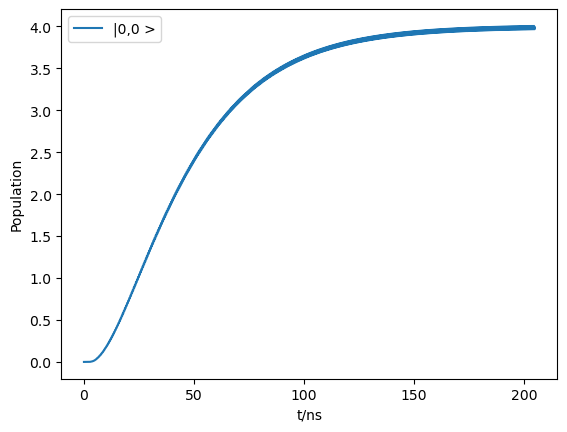

run end


In [425]:
r0=sq.run('',process='Hp',e_ops=[sq.upto('n',0,'r')])

# sq.c_ops

In [426]:
H,rho0,times=para
# len(H)
# H[1][0]
# op_dict['x']
# sq.upto(channel_name='x._0._r')
# ppppp

ALKT State Preparation Rotating Framework

In [574]:
def trunc(x,d):
    return Qobj(x[:d,:d])

I=trunc( op_dict['I'],3)

z=trunc( op_dict['sz02'],3)
x=trunc((op_dict['sx01']+op_dict['sx12'])/np.sqrt(2),3)
y=trunc((op_dict['sy01']+op_dict['sy12'])/np.sqrt(2),3)
Ir=trunc( op_dict['I'],10)
nr=trunc( op_dict['n'],10)

# sss=(tensor(x,x)+tensor(y,y)+tensor(z,z))
ss=(tensor(x,x,Ir)+tensor(y,y,Ir)+tensor(z,z,Ir))
nr_op=tensor(I,I,nr)
# -1j*projection(3,1,2)
r_eig=ss.eigenstates()

# ssss=(
#       tensor(x*x,I)+tensor(y*y,I)+tensor(z*z,I)+\
#       tensor(I,x*x)+tensor(I,y*y)+tensor(I,y*y)+\
#       2*tensor(x,x)+2*tensor(y,y)+2*tensor(z,z)).eigenstates()
ssss=(
      (tensor(x,I)+tensor(I,x))**2+\
      (tensor(y,I)+tensor(I,y))**2+\
      (tensor(z,I)+tensor(I,z))**2).eigenstates()

e_ops=[tensor(s.proj(),qeye(10)) for s in ssss[1]]
tot0=e_ops[0]
tot1=e_ops[1]+e_ops[2]+e_ops[3]
tot2=e_ops[4]+e_ops[5]+e_ops[6]+e_ops[7]+e_ops[8]
e_ops.extend([tot0,tot1,tot2,tensor(qeye(3),qeye(3),num(10))])


In [575]:
ssss

(array([4.4408921e-15, 2.0000000e+00, 2.0000000e+00, 2.0000000e+00,
        6.0000000e+00, 6.0000000e+00, 6.0000000e+00, 6.0000000e+00,
        6.0000000e+00]),
 array([Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
        Qobj data =
        [[ 0.        ]
         [ 0.        ]
         [-0.57735027]
         [ 0.        ]
         [ 0.57735027]
         [ 0.        ]
         [-0.57735027]
         [ 0.        ]
         [ 0.        ]]                                                    ,
        Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
        Qobj data =
        [[ 0.        ]
         [ 0.70710678]
         [ 0.        ]
         [-0.70710678]
         [ 0.        ]
         [ 0.        ]
         [ 0.        ]
         [ 0.        ]
         [ 0.        ]]                                                    ,
        Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
        Qobj data =
        [[ 0.        ]
      

In [576]:
coherent(5,1)

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[0.60655682]
 [0.60628133]
 [0.4303874 ]
 [0.24104351]
 [0.14552147]]

In [595]:
def qc_params_generator():
    w0_ge,w0_ef=4.5,4.25
    w1_ge,w1_ef=5.5,5.25
    wr=5
    g=0.1

    x0_ge,x0_ef=np.abs((g**2)/(w0_ge-wr)),np.abs(2*(g**2)/(w0_ef-wr))
    x1_ge,x1_ef=np.abs((g**2)/(w1_ge-wr)),np.abs(2*(g**2)/(w1_ef-wr))
    x0_gf=x0_ge+x0_ef
    x1_gf=x1_ge+x1_ef

    # x0_ge,x0_gf=0.040,0.0792
    # x1_ge,x1_gf=0.038,0.0760
    # x0_gf=x0_gf-x0_ge
    # x1_gf=x1_gf-x1_ge

    n=4
    kappa=2/1000

    D0=kappa/2
    # D0=0.1
    Dn=kappa
    # Dn=0
    ec=np.sqrt(n)*kappa/2


    Hs=[
        [x0_gf/2,           ['sz02','n'] ,'00','qr'],
        [(x0_ge-x0_ef)/2,   ['p11' ,'n'] ,'00','qr'],
        [x1_gf/2,           ['sz02','n'] ,'10','qr'],
        [(x1_ge-x1_ef)/2,   ['p11' ,'n'] ,'10','qr'],]
    H0=[
        [D0,['sx01'],'0'],
        [D0,['sx12'],'0'],
        [D0,['sx01'],'1'],
        [D0,['sx12'],'1'],
        ]
    # couple_list
    Hs.extend(H0)

    global qc_params
    qc_params=dict(
        qubit_num=2,        qubit_dim=3,
        w_q=[],          yita=[],
        T1=[500*1000,500*1000],       T2=[500*1000,500*1000],              
        Tphi=[],                  
        T1_ef=[500*1000,500*1000],    T2_ef=[500*1000,500*1000],           
        Tphi_ef=[],
        resonator_num=1,    resonator_dim=10,
        w_r=[],             kappa=[kappa],
        couple_list=Hs,
        relative_frame=True,   relative_eig=r_eig,
        )

mm=Model(qc_params=qc_params)

def Rabi_generator(name, w, amp,phase=0, edge=5, plat=30000):
    p_enve_pulse=[['cos_up'     ,   [0,  edge,   amp,  0]],
                  ['plat'       ,   [0,  plat,   amp,  0]]]  #,cos_LO_wave]
    p_enve=[0,p_enve_pulse]
    p_LO=[0,0,1,0,w,phase]
    p_tot= [['connect'  ,   p_enve ],
            ['cos'      ,   p_LO   ] ]
    mix_wave([0,p_tot],name)
    return name

# Rabi_generator('x0_gfn', 4.375, 0.05)

# process([[0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),'sx02' ,'0'],
#          [0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),'-sx02','1'],
#          [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),'-sy02','1'],
#          [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),'sy02' ,'0'],
#          ],'Hn')

# process([[0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,k       ),'x','0','r'],
#          ],'Hp')

p=process([
    [0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),['sx02'] ,'0'],
    [0,Rabi_generator('cosn',n*(x0_gf+x1_gf)/2,Dn      ),['-sx02'],'1'],
    [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),['-sy02'],'1'],
    [0,Rabi_generator('sinn',n*(x0_gf+x1_gf)/2,Dn,-pi/2),['sy02' ],'0'],
    [0,Rabi_generator('cosn',  (x0_gf+x1_gf)/2,2*ec    ),'x','0','r'],
    ],'Hn',f_sample=1)


In [596]:
print(x0_ge,x0_gf,x1_ge,x1_gf)

0.020000000000000004 0.046666666666666676 0.020000000000000004 0.10000000000000002


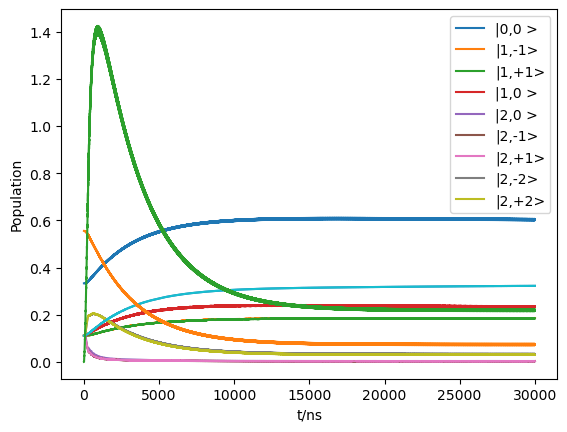

run end


type

In [597]:
rmm=mm.run(rho0='rhomm',process='Hn',e_ops=e_ops
          )
#   e_ops=nr_op)
# mm.upto(channel_name='sx02_0_q')
# complete_op_params(['sm01.',0])
type

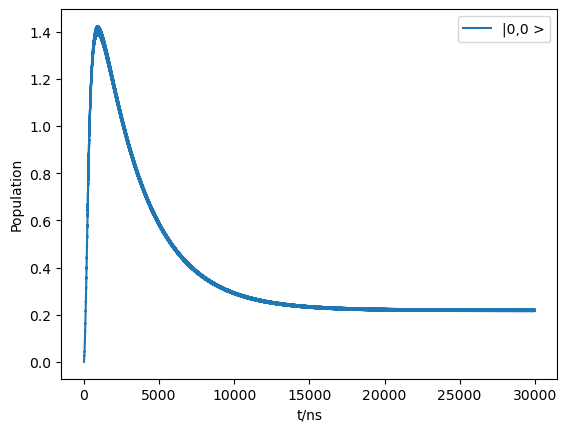

In [602]:
# mm.GateProcess(rmm,show_list=range(4))
# mm.GateProcess(rmm,show_list=[4,5,6,7,8])
# mm.GateProcess(rmm,show_list=[9,10,11])
mm.GateProcess(rmm,show_list=[-1])



# r0.


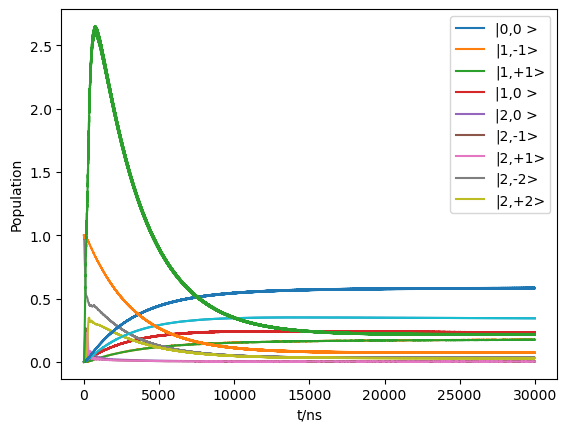

run end


In [603]:
rgg=mm.run(rho0='00_0',process='Hn',e_ops=e_ops
          )
#   e_ops=nr_op)
# mm.upto(channel_name='sx02_0_q')
# complete_op_params(['sm01.',0])

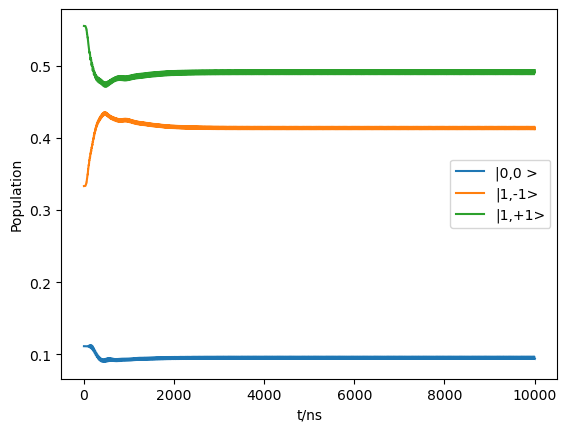

In [506]:
# mm.GateProcess(rmm,show_list=range(9))
# mm.GateProcess(rgg,show_list=[9,10,11])
# mm.GateProcess(rmm,show_list=[9,10,11])
# mm.GateProcess(rgg,show_list=[-1])
mm.GateProcess(rmm,show_list=[9,10,11])


# r0.


In [ ]:
mm.upt0('')

In [ ]:
r0=mm.run(process='Hn')
e_ops=[]
# mm.upto(channel_name='sx02_0_q')
# complete_op_params(['sm01.',0])

In [ ]:
r1=mm.run(pre_result=r0,process='Hn')

In [ ]:
p=process([
    # [0,'x0_ge0','x','0'],
    # [0,'x0_ef0','x','0'],
    [0,'x0_gfn','x','0'],

    # [0,'x1_ge0','x','1'],
    # [0,'x1_ef0','x','1'],
    # [0,'x1_gfn','x','1'],
    ],
    process_name='alkt_x')


In [ ]:
'''two photon'''

ALKT State Preparation

In [ ]:
qc_params=dict(
    qubit_num=2,        qubit_dim=4,
    w_q_list=[4.5,5.5],   yita_list=[0.25,0.25],
    resonator_num=1,    resonator_dim=4,
    w_r_list=[5],
    couple_list=[[0.02,'xx','00','qr'],
                 [0.02,'xx','10','qr']])
mm=Model(qc_params=qc_params)


In [ ]:
def Rabi_generator(name, w,     amp, edge=5, plat=10):
    p_enve_pulse=[['cos_up'     ,   [0,  edge,   amp,  0]],
                  ['plat'       ,   [0,  plat,   amp,  0]]]  #,cos_LO_wave]
    p_enve=[0,p_enve_pulse]
    p_LO=[0,0,1,0,w,0]
    p_tot= [['connect'  ,   p_enve ],
            ['cos'      ,   p_LO   ] ]
    return mix_wave([0,p_tot],name)



In [ ]:
Rabi_generator('x0_gfn', 4.375, 0.05)
Rabi_generator('x0_ge0', 4.5  , 0.1)
Rabi_generator('x0_ef0', 4.25 , 0.1)

Rabi_generator('x1_gfn', 5.375, 0.1)
Rabi_generator('x1_ge0', 5.5  , 0.1)
Rabi_generator('x1_ef0', 5.25 , 0.1)

In [ ]:
p=process([
    [0,'x0_ge0','x','0'],
    [0,'x0_ef0','x','0'],
    [0,'x0_gfn','x','0'],

    [0,'x1_ge0','x','1'],
    # [0,'x1_ef0','x','1'],
    # [0,'x1_gfn','x','1'],
    ],
    process_name='alkt_x')


In [ ]:
p.plot

In [ ]:
r=mm.run(process='alkt_x')

In [ ]:
p=mix_wave([[],
            ['sin',[15,5,0.05,]]])
p=process([[0,'plat','x','0']],process_name='plat')
# p.plot

In [ ]:
rr=mm.run(process='plat',pre_result=r)

In [ ]:
mm.es[0]

In [ ]:
r=qc.run(process='bus_x1')
len(r.times)
# p=process.process_dict['bus_x']
# p.plot
# qc.H_dict
# qc._generate_density_matrix('0')

In [ ]:
rr=qc.run(pre_result=r,process='bus_x1')
# len(r.times)

In [ ]:
rr.final_state.ptrace(0)

In [ ]:
Rabi1.plot

In [ ]:
# For example

# 1. qc.params  
qc_params=dict(
    couple_list=[[0.1,'01','xx'],[0.13,[1,2],'xx']],
    qubit_num=3,dim_num=4,
    w_q_list=[5,5.2,5.4],
    yita_list=[0.1,0.15,0.2]#
    # resonator_num=2,dim_num=6,
    # w_r_list=[7,8]
    )
# qc=qcircuit(qc_params=qc_params)
# qc.add_coupling([0.01,[0,2],'xx'])
# qc.direct_product_to_eigen_plot('001')
# qc.eigenstates_plot([1,3,5])
# qc.direct_product_state('010')

# 2. Model.params
# mod_params=dict(
#     pulse_dict=pulse_dict,
#     process_dict=process_dict
#     )
my_model=Model(
    qc_params=qc_params,
    mod_params=mod_params
    )


def f(t,p,t0):
    p_enve_name=[cos_upedge_wave,plat_wave,cos_downedge_wave]#,cos_LO_wave]
    p_enve_para=[[6,    t,1,0],
                 [3,    p,1,0],
                 [3,    t,1,0],]
    p_enve=[0,p_enve_name,p_enve_para]
    p_LO=[t0,1000,1,0,0.3,0]
    p_tot_name=[connect_wave,cos_LO_wave]
    p_tot_para=[p_enve,p_LO]
    return [5,p_tot_name,p_tot_para]
pulse0=mix_wave(f(10,20,0))
pulse1=mix_wave(f(10,20,pi))


In [ ]:
# qc.eigenstates_plot(range(3))
# np.transpose(qc.es)
qc.direct_product_to_eigen_plot('000')
# np.transpose(list(qc.es))
# np.transpose(qc.es[0])
# list(qc.es[0])
# list(np.transpose(qc.es[0])[0])
# np.matrix(sigmax())

In [ ]:
qc=simulation(qc_params=dict(qubit_num=3,dim_num=4,w_q_list=[5,5.3,5.4],yita_list=[0.1,0.15,0.2]))
# qc.add_coupling([1,[0,2],'xx'])
# qc.energies_plot
# s=simulation(qc,)
# s.H0
qc
# qc.energies_plot

In [ ]:
plot_wigner_fock_distribution(qc.eig[1][10])

In [ ]:
H = 2*np.pi * 0.1 * (sigmaz())+sigmax()
psi0 = basis(2, 1)

times = np.linspace(0.0, 100.0, 1000)
# psi0=basis(2,0)
result = mesolve(H, psi0, times, [np.sqrt(0.05) * sigmam(),np.sqrt(0.05) * sigmax()], e_ops=[
    sigmax(),
    sigmay(),
    sigmaz(),
    projection(2,0,0),
    projection(2,1,1),
    ],options=Options(store_final_state=True))
fig, ax = plt.subplots()
ax.plot(times, result.expect[0])
ax.plot(times, result.expect[1])
ax.plot(times, result.expect[2])


ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
ax.legend(("Sigma-X", "Sigma-Y",'sz'))
plt.show()

fig, ax = plt.subplots()
ax.plot(times, result.expect[3])
ax.plot(times, result.expect[4])
# ax.plot(times, result.expect[2])

b=Bloch()
b.add_points([result.expect[0],result.expect[1],
              result.expect[2]],'l')
b.show()

result.final_state